# `2017 - 2022` Analysis

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from itertools import combinations
from collections import defaultdict

# Notes

> Code does a good job of filtering for `2017 - 2018`. 

> Needs to be tuned up for `2019 - 2022` because file changes occurred again, but mainly just file location

> For the sake of time, at the moment will settle for just moving on to include only directly relevant data to our analysis because of complication making the dataset play nice for `2017-2018` and `2019-2022`.

> For `2019 - 2022` need to find `DEATHINED`. Also for all years need dictionary to translate `SEX`, `EDDISCHARGEDISPOSITION`, `DEATHINED`, `HOSPDISCHARGEDISPOSITION`.

In [2]:
data_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/Data/Raw_data/PUF AY %i/CSV/'
years = range(2017, 2023)
thoracotomy_codes = ['0WJB0ZZ', '0WJ90ZZ', '02JA0ZZ', '02JY0ZZ', '0BJL0ZZ', '0BJK0ZZ', '0BJQ0ZZ','0WJ80ZZ', '0WJC0ZZ', '0WJD0ZZ', '02VW0CZ', '02QA0ZZ', '3E080GC']
sternotomy_codes = ['0P800ZZ']

mechanism_code_dict = {1:'Cut/pierce', 2:'Drowning/submersion', 3:'Fall', 4:'Fire/flame', 5:'Hot object/substance', 6:'Firearm', 7:'Machinery', 8:'MVT Occupant', 9:'MVT Motorcyclist', 10:'MVT Pedal cyclist', 11:'MVT Pedestrian', 12:'MVT Unspecified', 13:'MVT Other', 14:'Pedal cyclist, other', 15:'Pedestrian, other', 16:'Transport, other', 17:'Natural/environmental,  Bites and stings', 18:'Natural/environmental,  Other', 19:'Overexertion', 20:'Poisoning', 21:'Struck by, against', 22:'Suffocation', 23:'Other specified and classifiable', 24:'Other specified, not elsewhere classifiable', 25:'Unspecified', 26:'Adverse effects, medical care', 27:'Adverse effects, drugs'} # As noted in PUF dictionary
trauma_type_code_dict = {1:'Blunt', 2:'Penetrating', 3:'Burn', 4:'Other/unspecified', 9:'Activity Code - Not Valid as a Primary E-Code'} # As noted in PUF Dictionary
sex_code_dict = {1:'Male', 2:'Female'}
eddischarge_code_dict = {1: 'Floor bed (general admission, non-specialty unit bed)', 2: 'Observation unit (unit that provides < 24 hour stays)', 3: 'Telemetry/step-down unit (less acuity than ICU)', 4: 'Home with services', 5: 'Deceased/expired', 6: 'Other (jail, institutional care, mental health, etc.)', 7: 'Operating Room', 8: 'Intensive Care Unit (ICU)', 9: 'Home without services', 10: 'Left against medical advice', 11: 'Transferred to another hospital'}
hospdischarge_disposition_code_dict = {1: 'Discharged/Transferred to a short-term general hospital for inpatient care', 2: 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 3: 'Discharged/Transferred to home under care of organized home health service', 4: 'Left against medical advice or discontinued care', 5: 'Deceased/Expired', 6: 'Discharged to home or self-care (routine discharge)', 7: 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 8: 'Discharged/Transferred to hospice care', 10: 'Discharged/Transferred to court/law enforcement', 11: 'Discharged/Transferred to inpatient rehab or designated unit', 12: 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 13: 'Discharged/Transferred to a psychiatric hospital or psychiatric distinct part unit of a hospital', 14: 'Discharged/Transferred to another type of institution not defined elsewhere'}

cols17 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols19 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols17 = [x.upper() for x in cols17]
cols19 = [x.upper() for x in cols19]

common_cols = list(set(cols17) & set(cols19))

In [3]:
for year in years:
    
    if year in range(2017, 2019):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    elif year in range(2019, 2023):
        TRAUMA_df = pd.read_csv(data_fp%year + 'PUF_TRAUMA.csv')
        ICDPROCEDURE_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE.csv')
        ICDPROCEDURE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ICDPROCEDURE_LOOKUP.csv')
        ECODE_LOOKUP_df = pd.read_csv(data_fp%year + 'PUF_ECODE_LOOKUP.csv')
    else:
        pass
    
    TRAUMA_df.columns = map(str.upper, TRAUMA_df.columns)
    ICDPROCEDURE_df.columns = map(str.upper, ICDPROCEDURE_df.columns)
    ICDPROCEDURE_LOOKUP_df.columns = map(str.upper, ICDPROCEDURE_LOOKUP_df.columns)
    ECODE_LOOKUP_df.columns = map(str.upper, ECODE_LOOKUP_df.columns)
    
    if year in range(2019, 2023):
        ICDPROCEDURE_df['PROCEDUREMINS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTHRS']*60
        ICDPROCEDURE_df['PROCEDUREDAYS'] = ICDPROCEDURE_df['HOSPITALPROCEDURESTARTDAYS']
    else:
        pass
    
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[:, ['INC_KEY', 'ICDPROCEDURECODE', 'PROCEDUREMINS', 'PROCEDUREDAYS']]
    potential_thoracotomy = ICDPROCEDURE_df.loc[ICDPROCEDURE_df['ICDPROCEDURECODE'].isin(thoracotomy_codes)]
    potential_thoracotomy = potential_thoracotomy.loc[potential_thoracotomy['PROCEDUREMINS'] <= 20.0]
    potential_thoracotomy = potential_thoracotomy.loc[potential_thoracotomy['PROCEDUREDAYS'] <= 1.0]
    potential_thoracotomy_cases = np.unique(potential_thoracotomy['INC_KEY'])
    sternotomy_cases = ICDPROCEDURE_df.loc[ICDPROCEDURE_df['ICDPROCEDURECODE'].isin(sternotomy_codes)]
    sternotomy_cases = np.unique(sternotomy_cases['INC_KEY'])
    thoracotomy_cases = [x for x in potential_thoracotomy_cases if x not in sternotomy_cases]
    ICDPROCEDURE_df = ICDPROCEDURE_df.loc[ICDPROCEDURE_df['INC_KEY'].isin(thoracotomy_cases)]
    
    ICDPROCEDURE_LOOKUP_df = ICDPROCEDURE_LOOKUP_df.loc[:, ['ICDPROCEDURECODE', 'ICDPROCEDURECODE_DESC']]
    ECODE_LOOKUP_df = ECODE_LOOKUP_df.loc[:, ['ECODE', 'ECODE_DESC', 'MECHANISM', 'TRAUMATYPE']]
    
    procedure_dict = dict(zip(ICDPROCEDURE_LOOKUP_df['ICDPROCEDURECODE'], ICDPROCEDURE_LOOKUP_df['ICDPROCEDURECODE_DESC'])) # create dictionary
    ICDPROCEDURE_df['ICDPROCEDURECODE'] = ICDPROCEDURE_df['ICDPROCEDURECODE'].replace(procedure_dict) # implement dictionary
    
    trauma_cols = np.unique(['INC_KEY', 'PRIMARYECODEICD10', 'AGEYEARS', 'SEX', 'EDDISCHARGEDISPOSITION', 'HOSPDISCHARGEDISPOSITION'] + common_cols)
    TRAUMA_df = TRAUMA_df.loc[:, trauma_cols]
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['INC_KEY'].isin(np.unique(ICDPROCEDURE_df['INC_KEY']))]
    
    ecode_dict = dict(zip(ECODE_LOOKUP_df['ECODE'], ECODE_LOOKUP_df['ECODE_DESC'])) # create dictionary
    TRAUMA_df['PRIMARYECODEICD10'] = TRAUMA_df['PRIMARYECODEICD10'].replace(ecode_dict) # implement dictionary
    
    mechanism_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['MECHANISM'])) # create dictionary
    TRAUMA_df['MECHANISM'] = TRAUMA_df['PRIMARYECODEICD10'].map(mechanism_dict) # implement dictionary
    
    traumatype_dict = dict(zip(ECODE_LOOKUP_df['ECODE_DESC'], ECODE_LOOKUP_df['TRAUMATYPE'])) # create dictionary
    TRAUMA_df['TRAUMATYPE'] = TRAUMA_df['PRIMARYECODEICD10'].map(traumatype_dict) # implement dictionary
    
    TRAUMA_df['MECHANISM'] = TRAUMA_df['MECHANISM'].replace(mechanism_code_dict) # implement dictionary
    
    TRAUMA_df['TRAUMATYPE'] = TRAUMA_df['TRAUMATYPE'].replace(trauma_type_code_dict) # implement dictionary
    
    TRAUMA_df['SEX'] = TRAUMA_df['SEX'].replace(sex_code_dict)
    
    TRAUMA_df['EDDISCHARGEDISPOSITION'] = TRAUMA_df['EDDISCHARGEDISPOSITION'].replace(eddischarge_code_dict) # implement dictionary
    
    TRAUMA_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_df['HOSPDISCHARGEDISPOSITION'].replace(hospdischarge_disposition_code_dict) # implement dictionary
    
    TRAUMA_df = TRAUMA_df.loc[TRAUMA_df['TRAUMATYPE'].isin(['Blunt', 'Penetrating'])]
    
    TRAUMA_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/TRAUMA_df_%i.csv'%year, index=False)
    ICDPROCEDURE_df.to_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/ICDPROCEDURE_df_%i.csv'%year, index=False)
    
    display(ICDPROCEDURE_df.head())
    display(TRAUMA_df.head())

INC_KEY                                   ICDPROCEDURECODE  \
8989  170000020367  Insertion of Infusion Device into Right Femora...   
8990  170000020367      Performance of Cardiac Output, Single, Manual   
8991  170000020367  Repair Thoracic Aorta, Ascending/Arch, Open Ap...   
8992  170000020367  Transfusion of Nonautologous Red Blood Cells i...   
8993  170000020367  Transfusion of Nonautologous Frozen Plasma int...   

      PROCEDUREMINS  PROCEDUREDAYS  
8989            7.0            1.0  
8990           12.0            1.0  
8991           12.0            1.0  
8992            9.0            1.0  
8993            NaN            NaN

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
1825                 NaN                     1.0          2.0   
2473                 NaN                     1.0          2.0   
2784                 NaN                     1.0          2.0   
2841                 NaN                     1.0          2.0   
3641                 NaN                     1.0          2.0   

      ABUSEREPORT_BIU ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
1825              NaN                  NaN                       1.0   
2473              NaN                  NaN                       1.0   
2784              NaN                  NaN                       1.0   
2841              NaN                  NaN                       1.0   
3641              NaN                  NaN                       1.0   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
1825      24.0                     0                   1   
2473      29.0                     0                   1   
2784      28.0                     0                   1   
2841      17.0                     0                   1   
3641      30.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  \
1825                      0  ...      0            2.0                NaN   
2473                      0  ...      1            2.0                NaN   
2784                      0  ...      0            2.0                NaN   
2841                      0  ...      0            2.0                NaN   
3641                      0  ...      0            2.0                NaN   

      WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  \
1825                NaN                NaN          2.0              NaN   
2473                NaN                NaN          2.0              NaN   
2784                NaN                NaN          2.0              NaN   
2841                NaN                NaN          2.0              NaN   
3641                NaN                NaN          2.0              NaN   

      YODISCH  MECHANISM   TRAUMATYPE  
1825   2017.0    Firearm  Penetrating  
2473   2017.0    Firearm  Penetrating  
2784      NaN    Firearm  Penetrating  
2841      NaN    Firearm  Penetrating  
3641      NaN    Firearm  Penetrating  

[5 rows x 332 columns]

INC_KEY                                   ICDPROCEDURECODE  \
8912  180014722297                 Inspection of Heart, Open Approach   
8913  180014722297      Performance of Cardiac Output, Single, Manual   
8914  180014722297  Drainage of Right Pleural Cavity with Drainage...   
9134  180014722297  Insertion of Endotracheal Airway into Trachea,...   
9135  180014722297  Respiratory Ventilation, Less than 24 Consecut...   

      PROCEDUREMINS  PROCEDUREDAYS  
8912            9.0            1.0  
8913            2.0            1.0  
8914            4.0            1.0  
9134           10.0            1.0  
9135            0.0            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
2646                 NaN                     1.0          2.0   
3257                 NaN                     1.0          2.0   
4440                 NaN                     1.0          2.0   
5618                 NaN                     1.0          2.0   
7239                 NaN                     1.0          2.0   

      ABUSEREPORT_BIU ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
2646              NaN                  NaN                       1.0   
3257              NaN                  NaN                       1.0   
4440              NaN                  NaN                       1.0   
5618              NaN                  NaN                       1.0   
7239              NaN                  NaN                       1.0   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
2646      24.0                     0                   1   
3257      71.0                     0                   1   
4440      22.0                     0                   1   
5618      38.0                     0                   1   
7239      47.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  \
2646                      0  ...      0            2.0                NaN   
3257                      0  ...      1            2.0                NaN   
4440                      0  ...      0            2.0                NaN   
5618                      0  ...      1            2.0                NaN   
7239                      0  ...      0            2.0                NaN   

      WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  \
2646                NaN                NaN          2.0              NaN   
3257                NaN                NaN          2.0              NaN   
4440                NaN                NaN          2.0              NaN   
5618                NaN                NaN          1.0              NaN   
7239                NaN                NaN          2.0              NaN   

      YODISCH                         MECHANISM   TRAUMATYPE  
2646   2018.0                           Firearm  Penetrating  
3257      NaN                           Firearm  Penetrating  
4440   2018.0                           Firearm  Penetrating  
5618   2018.0  Other specified and classifiable        Blunt  
7239   2018.0                      MVT Occupant        Blunt  

[5 rows x 332 columns]

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


INC_KEY                                   ICDPROCEDURECODE  \
15472  190031200522  Drainage of Right Pleural Cavity with Drainage...   
15473  190031200522   Inspection of Left Pleural Cavity, Open Approach   
15474  190031200522  Occlusion of Thoracic Aorta, Descending with I...   
15475  190031200522  Insertion of Endotracheal Airway into Trachea,...   
15476  190031200522  Occlusion of Thoracic Aorta, Descending with I...   

       PROCEDUREMINS  PROCEDUREDAYS  
15472            3.0            1.0  
15473            1.8            1.0  
15474            3.0            1.0  
15475            6.0            1.0  
15476           10.2            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  ABUSEREPORT_BIU  \
4                   NaN                     1.0          2.0              NaN   
19                  NaN                     1.0          2.0              NaN   
156                 NaN                     1.0          2.0              NaN   
373                 NaN                     1.0          2.0              NaN   
798                 NaN                     1.0          2.0              NaN   

    ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  AGEYEARS  \
4                    NaN                       1.0      47.0   
19                   NaN                       1.0      40.0   
156                  NaN                       1.0      21.0   
373                  NaN                       1.0      19.0   
798                  NaN                       1.0      42.0   

     AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  AIRBAG_DEPLOYED_OTHER  ...  \
4                       0                   1                      0  ...   
19                      0                   1                      0  ...   
156                     0                   1                      0  ...   
373                     0                   1                      0  ...   
798                     0                   1                      0  ...   

     WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  \
4        0            2.0                NaN                NaN   
19       0            2.0                NaN                NaN   
156      0            2.0                NaN                NaN   
373      0            2.0                NaN                NaN   
798      0            2.0                NaN                NaN   

     WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  YODISCH   MECHANISM  \
4                  NaN          2.0              NaN      NaN  Cut/pierce   
19                 NaN          2.0              NaN      NaN     Firearm   
156                NaN          2.0              NaN      NaN     Firearm   
373                NaN          2.0              NaN      NaN     Firearm   
798                NaN          1.0              NaN      NaN        Fall   

      TRAUMATYPE  
4    Penetrating  
19   Penetrating  
156  Penetrating  
373  Penetrating  
798        Blunt  

[5 rows x 332 columns]

/Users/JakeCanfield/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


INC_KEY                                   ICDPROCEDURECODE  \
13404  200043224492                        Repair Heart, Open Approach   
13405  200043224492  Insertion of Intraluminal Device into Right Fe...   
13406  200043224492  Insertion of Infusion Device into Right Femora...   
13407  200043224492                  Excision of Spleen, Open Approach   
13408  200043224492               Excision of Left Lung, Open Approach   

       PROCEDUREMINS  PROCEDUREDAYS  
13404           49.8            1.0  
13405            NaN            1.0  
13406            NaN            1.0  
13407           49.8            1.0  
13408           49.8            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
2010                 NaN                     NaN          NaN   
2871                 NaN                     NaN          NaN   
6882                 NaN                     NaN          NaN   
7027                 NaN                     NaN          NaN   
7271                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
2010              NaN                   NaN                       NaN   
2871              NaN                   NaN                       NaN   
6882              NaN                   NaN                       NaN   
7027              NaN                   NaN                       NaN   
7271              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
2010      26.0                     0                   1   
2871      60.0                     0                   1   
6882      37.0                     0                   1   
7027      41.0                     0                   1   
7271      20.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  \
2010                      0  ...      0            2.0                NaN   
2871                      0  ...      1            2.0                NaN   
6882                      0  ...      1            2.0                NaN   
7027                      0  ...      1            2.0                NaN   
7271                      0  ...      0            2.0                NaN   

      WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  \
2010                NaN                NaN          2.0              NaN   
2871                NaN                NaN          2.0              NaN   
6882                NaN                NaN          2.0              NaN   
7027                NaN                NaN          2.0              NaN   
7271                NaN                NaN          2.0              NaN   

      YODISCH       MECHANISM   TRAUMATYPE  
2010      NaN         Firearm  Penetrating  
2871      NaN  MVT Pedestrian        Blunt  
6882      NaN         Firearm  Penetrating  
7027      NaN         Firearm  Penetrating  
7271      NaN         Firearm  Penetrating  

[5 rows x 332 columns]

INC_KEY                                   ICDPROCEDURECODE  \
12941  210057983007  Occlusion of Thoracic Aorta, Descending with I...   
12942  210057983007                        Repair Heart, Open Approach   
12943  210057983007  Insertion of Infusion Device into Right Subcla...   
12944  210057983007  Insertion of Endotracheal Airway into Trachea,...   
12945  210057983007  Drainage of Right Pleural Cavity with Drainage...   

       PROCEDUREMINS  PROCEDUREDAYS  
12941            NaN            1.0  
12942            1.8            1.0  
12943            NaN            1.0  
12944            1.8            1.0  
12945            6.0            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
1695                 NaN                     NaN          NaN   
1714                 NaN                     NaN          NaN   
1764                 NaN                     NaN          NaN   
1828                 NaN                     NaN          NaN   
1843                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
1695              NaN                   NaN                       NaN   
1714              NaN                   NaN                       NaN   
1764              NaN                   NaN                       NaN   
1828              NaN                   NaN                       NaN   
1843              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
1695      29.0                     0                   1   
1714      26.0                     0                   1   
1764       NaN                     0                   1   
1828       NaN                     0                   1   
1843      24.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  \
1695                      0  ...      0            2.0                NaN   
1714                      0  ...      0            2.0                NaN   
1764                      0  ...      0            2.0                NaN   
1828                      0  ...      0            2.0                NaN   
1843                      0  ...      0            2.0                NaN   

      WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  \
1695                NaN                NaN          2.0              NaN   
1714                NaN                NaN          2.0              NaN   
1764                NaN                NaN          2.0              NaN   
1828                NaN                NaN          NaN              2.0   
1843                NaN                NaN          2.0              NaN   

      YODISCH  MECHANISM   TRAUMATYPE  
1695      NaN    Firearm  Penetrating  
1714      NaN    Firearm  Penetrating  
1764      NaN    Firearm  Penetrating  
1828      NaN    Firearm  Penetrating  
1843      NaN    Firearm  Penetrating  

[5 rows x 332 columns]

INC_KEY                                   ICDPROCEDURECODE  \
4686  220063640246  Insertion of Endotracheal Airway into Trachea,...   
4687  220063640246  Drainage of Right Pleural Cavity with Drainage...   
4688  220063640246  Drainage of Left Pleural Cavity with Drainage ...   
4689  220063640246  Inspection of Right Pleural Cavity, Open Approach   
4690  220063640246   Inspection of Left Pleural Cavity, Open Approach   

      PROCEDUREMINS  PROCEDUREDAYS  
4686            3.0            1.0  
4687            4.2            1.0  
4688            4.8            1.0  
4689            4.8            1.0  
4690            4.8            1.0

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  \
736                  NaN                     NaN          NaN   
783                  NaN                     NaN          NaN   
1302                 NaN                     NaN          NaN   
1754                 NaN                     NaN          NaN   
3289                 NaN                     NaN          NaN   

      ABUSEREPORT_BIU  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  \
736               NaN                   NaN                       NaN   
783               NaN                   NaN                       NaN   
1302              NaN                   NaN                       NaN   
1754              NaN                   NaN                       NaN   
3289              NaN                   NaN                       NaN   

      AGEYEARS  AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  \
736       58.0                     0                   1   
783       79.0                     0                   1   
1302      28.0                     0                   1   
1754      17.0                     0                   1   
3289      38.0                     0                   1   

      AIRBAG_DEPLOYED_OTHER  ...  WHITE  WITHDRAWALLST  WITHDRAWALLSTDAYS  \
736                       0  ...      0            2.0                NaN   
783                       0  ...      1            2.0                NaN   
1302                      0  ...      0            2.0                NaN   
1754                      0  ...      0            2.0                NaN   
3289                      0  ...      0            2.0                NaN   

      WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  WORKRELATED  WORKRELATED_BIU  \
736                 NaN                NaN          2.0              NaN   
783                 NaN                NaN          2.0              NaN   
1302                NaN                NaN          2.0              NaN   
1754                NaN                NaN          2.0              NaN   
3289                NaN                NaN          2.0              NaN   

      YODISCH       MECHANISM   TRAUMATYPE  
736       NaN         Firearm  Penetrating  
783       NaN  MVT Pedestrian        Blunt  
1302      NaN         Firearm  Penetrating  
1754      NaN         Firearm  Penetrating  
3289      NaN  MVT Pedestrian        Blunt  

[5 rows x 332 columns]

## Devising way to get thoracotomies that started on the left `ONLY`

> Shouldn't be any right thoracotomies before left in true EDT protocol.

> Also found in the data that there are additional thoracotomies performed on the same patient, sometimes as short as within 30 minutes of each other (i.e. at 18 min and 48 min following arrival to the ED)

> Below code block needs to be tuned up to work correctly

# What questions should I be asking next?

*Several of these are likely independent projects of their own*

1. Age guideline/ cutoff
    - Create age vs mortality graph, hue = injury type
    - Can compare over the years
    - Histogram of age
2. Mortality based on timing and performing EDT (mortality rate too excessive if not performed within x minutes)
    - Mortality vs. PROCEDUREMINS for thoracotomy, hue = injury type
3. Complications/ comorbidity
    - probably has to be in a table format
4. Evaluate WTA/ EAST guidelines vs not followed
    - will be more complicated, could mainly focus on pre-hospital cpr time and sol for criteria
5. Create a machine learning algorithm using small subset of data, ideally data that is easily integrated across all years into one dataframe (simple is better given the complexity of machine learning and lack of ability to get substantial advising on the technical side).
    - Will likely need to stay within the realm of linear regression models that I am already familiar with if this is to be pursued. Plus this will help keep clinical people happy when trying to explain as AI/ NN solutions quickly just become mysterious black box of confusion

# Progress Note to Self:

> Was able to generate table with some information (not everything) combined, in theory I think this is enough to do the project.

> Next steps for today would be to create a dataframe that has `ED Mortality`, `Hospital Mortality` and `Overall Mortality` calculated for `2017 -  2022`. 

> We can use unique `INC_KEY` to select the unique individuals for the mortality calculations. In terms of data exploration of the data available, we can make the following figures:
    - Histogram of age
    - Bar plot comparing female vs male cases
    - Plot showing number of `ICDPROCEDURECODE` used for various mechanisms of injury
    - Plot showing people who died in the ED vs hospital
    - Plot of injury type
    - Plot of mechanism (i.e. firearm etc.)
    - Plot of time to first procedure for each of the potential thoracotomy labels
    - ED/ HOSP mortality vs age, hue = MOI, include all years
    
> **Update** return to above for data and code into dictionary that for `SEX` there is a value `3.0` which is presumed to be unknown (although this is not specified in the `NTDB Data Dictionary`.

> **Update** NaN values need to be converted for ED/HOSP DISPO to be shown as unknown

# Data Exploration of Thoracotomy Data Population

## Combine years of data into one `DataFrame` for figure generation

In [4]:
years = range(2017, 2023)
TRAUMA_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/TRAUMA_df_%i.csv'
ICDPROCEDURE_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/ICDPROCEDURE_df_%i.csv'
TRAUMA_cols = pd.read_csv(TRAUMA_fp%2017, nrows=1).columns.tolist().append('Year')
ICDPROCEDURE_cols = pd.read_csv(ICDPROCEDURE_fp%2017, nrows=1).columns.tolist().append('Year')

TRAUMA_all_df = pd.DataFrame(columns=TRAUMA_cols)
ICDPROCEDURE_all_df = pd.DataFrame(columns=ICDPROCEDURE_cols)

for year in years:
    trauma_df = pd.read_csv(TRAUMA_fp%year)
    trauma_df['Year'] = year
    icdprocedure_df = pd.read_csv(ICDPROCEDURE_fp%year)
    icdprocedure_df['Year'] = year
    TRAUMA_all_df = pd.concat([TRAUMA_all_df, trauma_df], ignore_index=True)
    ICDPROCEDURE_all_df = pd.concat([ICDPROCEDURE_all_df, icdprocedure_df], ignore_index=True)

TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'] = TRAUMA_all_df['HOSPDISCHARGEDISPOSITION'].fillna('Unknown')
TRAUMA_all_df['EDDISCHARGEDISPOSITION'] = TRAUMA_all_df['EDDISCHARGEDISPOSITION'].fillna('Unknown')
TRAUMA_all_df['SEX'] = TRAUMA_all_df['SEX'].replace('3.0', 'Unknown')

display(TRAUMA_all_df.head())
print(np.shape(TRAUMA_all_df))
display(ICDPROCEDURE_all_df.head())
print(np.shape(ICDPROCEDURE_all_df))

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  ABUSEREPORT_BIU  \
0                 NaN                     1.0          2.0              NaN   
1                 NaN                     1.0          2.0              NaN   
2                 NaN                     1.0          2.0              NaN   
3                 NaN                     1.0          2.0              NaN   
4                 NaN                     1.0          2.0              NaN   

  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  AGEYEARS  \
0                  NaN                       1.0      24.0   
1                  NaN                       1.0      29.0   
2                  NaN                       1.0      28.0   
3                  NaN                       1.0      17.0   
4                  NaN                       1.0      30.0   

   AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  AIRBAG_DEPLOYED_OTHER  ...  \
0                     0                   1                      0  ...   
1                     0                   1                      0  ...   
2                     0                   1                      0  ...   
3                     0                   1                      0  ...   
4                     0                   1                      0  ...   

   WITHDRAWALLST  WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  \
0            2.0                NaN                NaN                NaN   
1            2.0                NaN                NaN                NaN   
2            2.0                NaN                NaN                NaN   
3            2.0                NaN                NaN                NaN   
4            2.0                NaN                NaN                NaN   

   WORKRELATED  WORKRELATED_BIU  YODISCH  MECHANISM   TRAUMATYPE  Year  
0          2.0              NaN   2017.0    Firearm  Penetrating  2017  
1          2.0              NaN   2017.0    Firearm  Penetrating  2017  
2          2.0              NaN      NaN    Firearm  Penetrating  2017  
3          2.0              NaN      NaN    Firearm  Penetrating  2017  
4          2.0              NaN      NaN    Firearm  Penetrating  2017  

[5 rows x 333 columns]

(13997, 333)


INC_KEY                                   ICDPROCEDURECODE  \
0  170000020367  Insertion of Infusion Device into Right Femora...   
1  170000020367      Performance of Cardiac Output, Single, Manual   
2  170000020367  Repair Thoracic Aorta, Ascending/Arch, Open Ap...   
3  170000020367  Transfusion of Nonautologous Red Blood Cells i...   
4  170000020367  Transfusion of Nonautologous Frozen Plasma int...   

   PROCEDUREMINS  PROCEDUREDAYS  Year  
0            7.0            1.0  2017  
1           12.0            1.0  2017  
2           12.0            1.0  2017  
3            9.0            1.0  2017  
4            NaN            NaN  2017

(175785, 5)


## Age Demographics

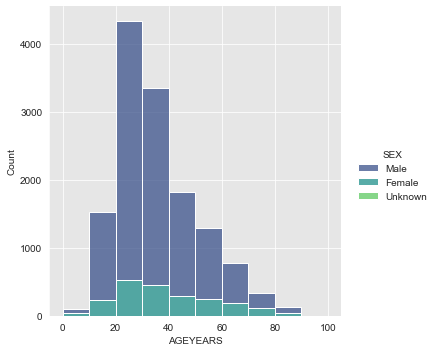

In [5]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='SEX',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

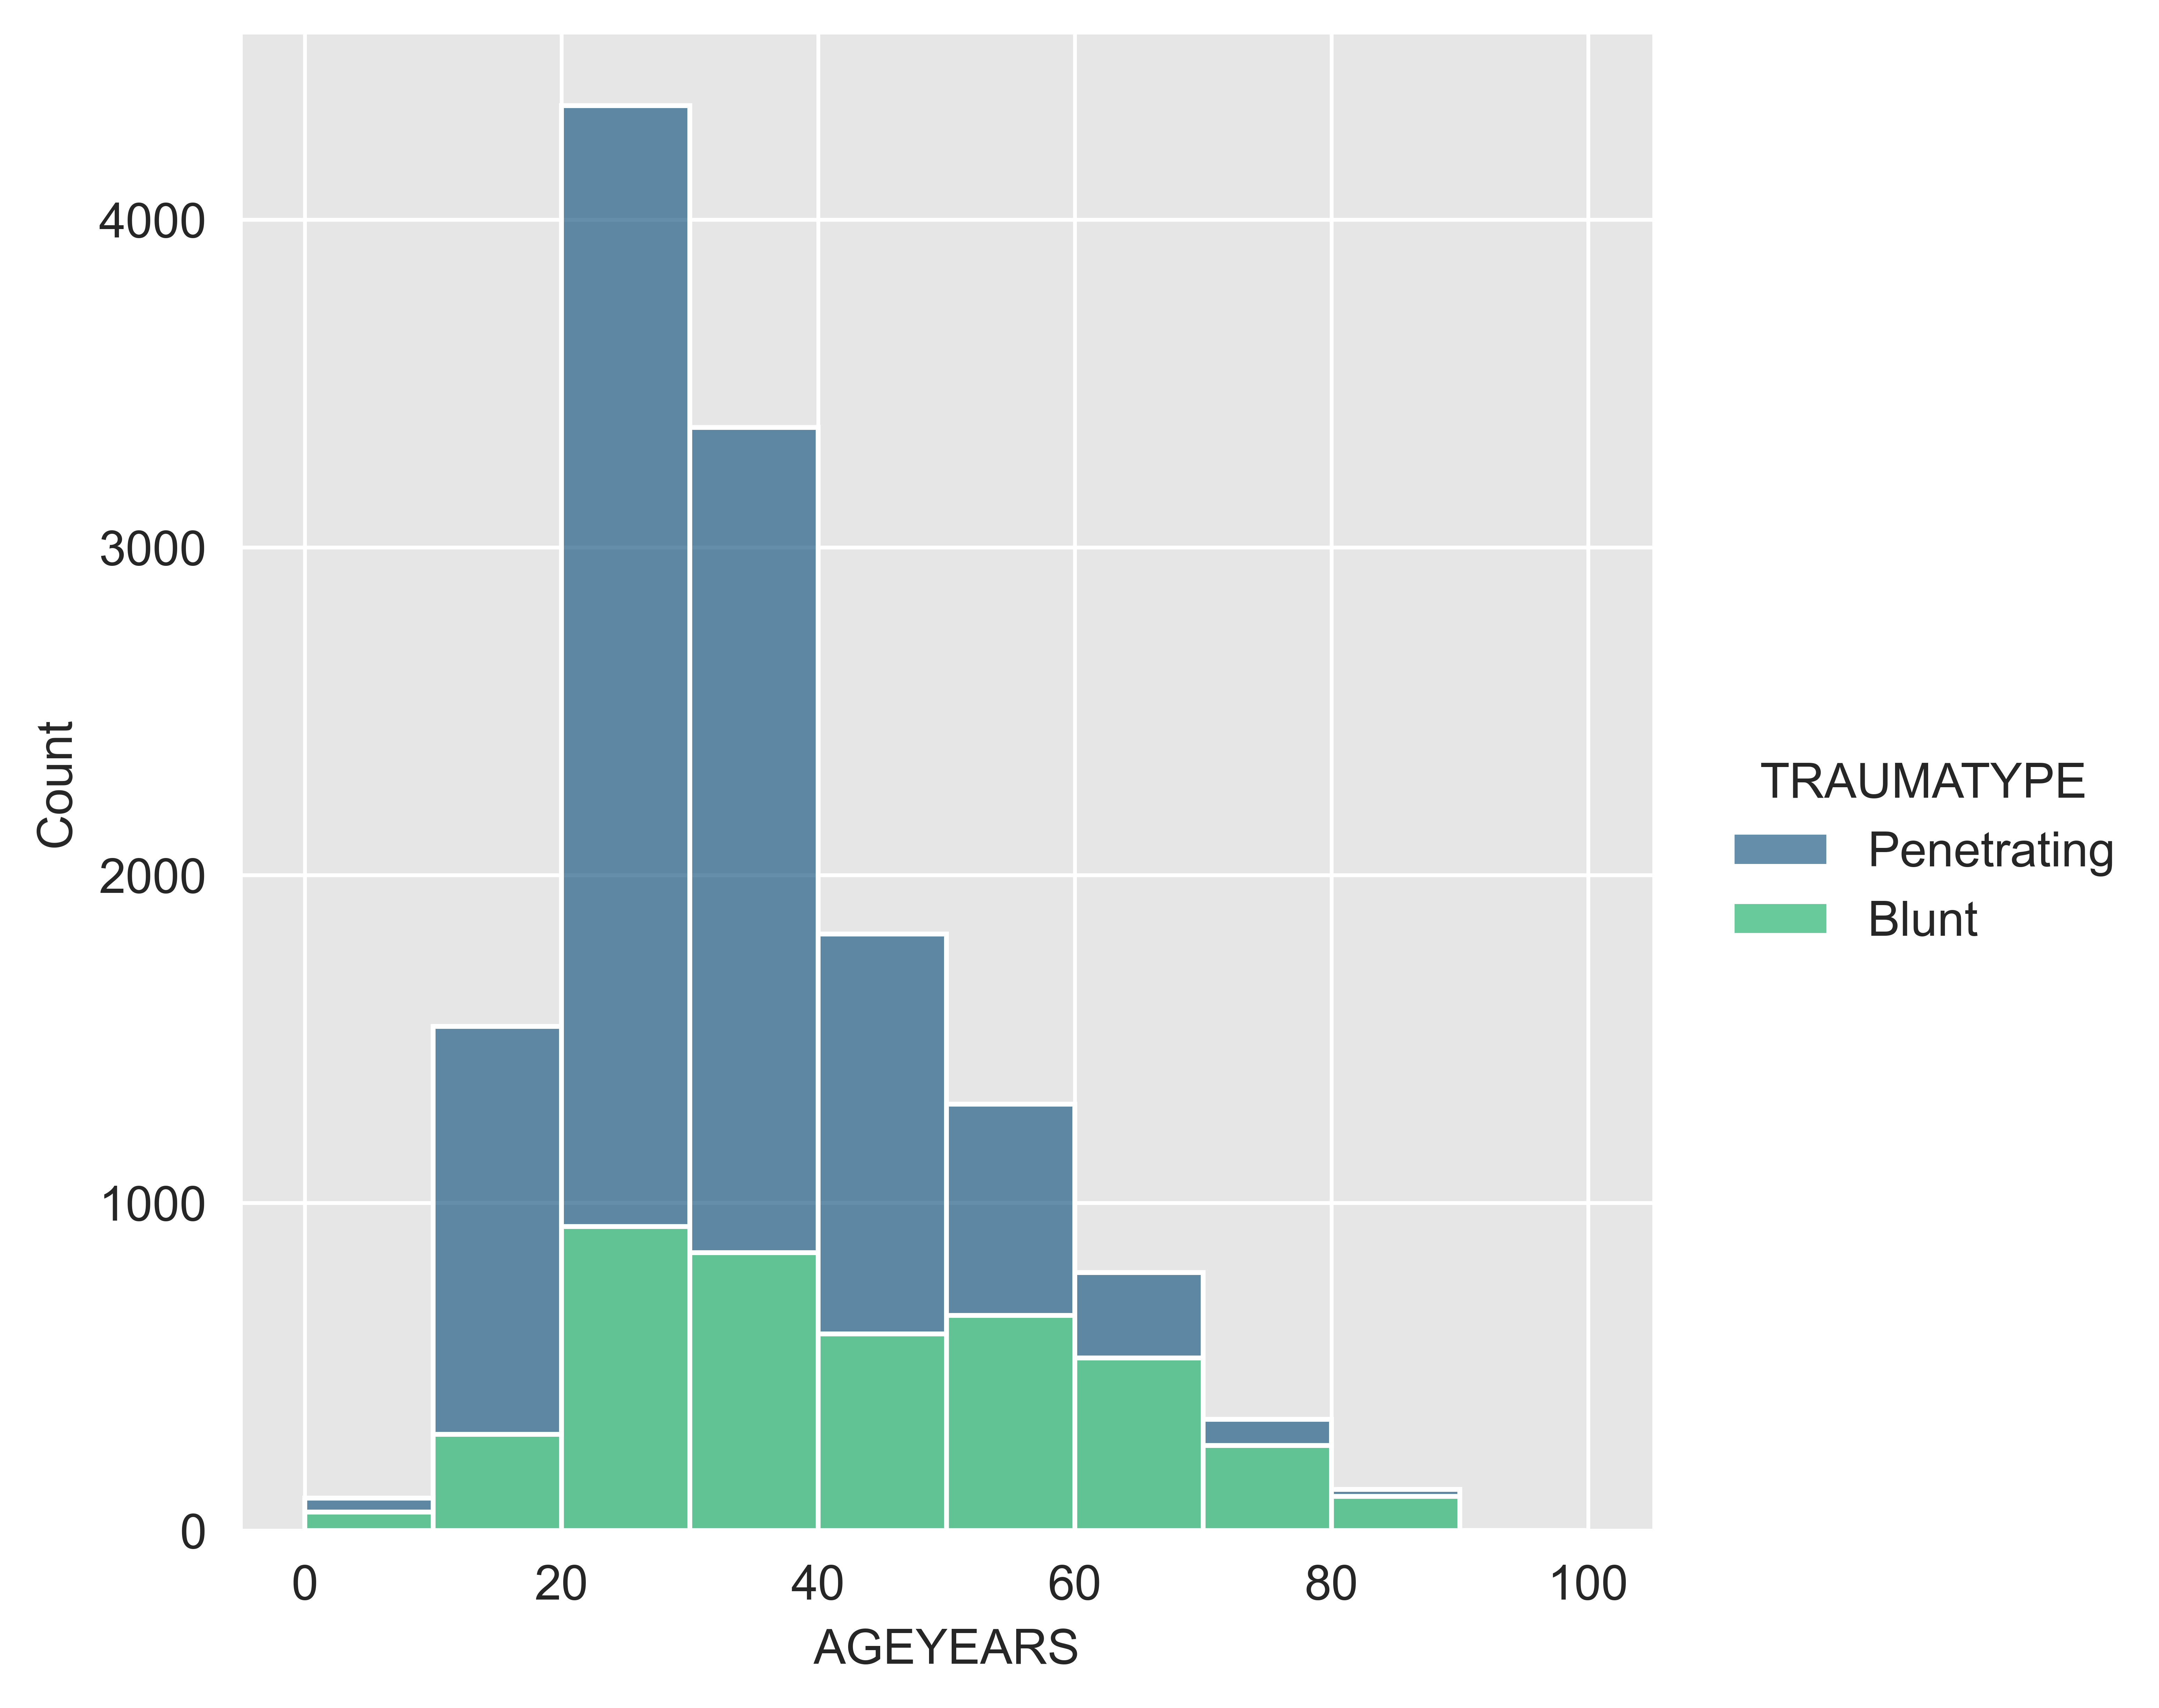

In [6]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='TRAUMATYPE',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

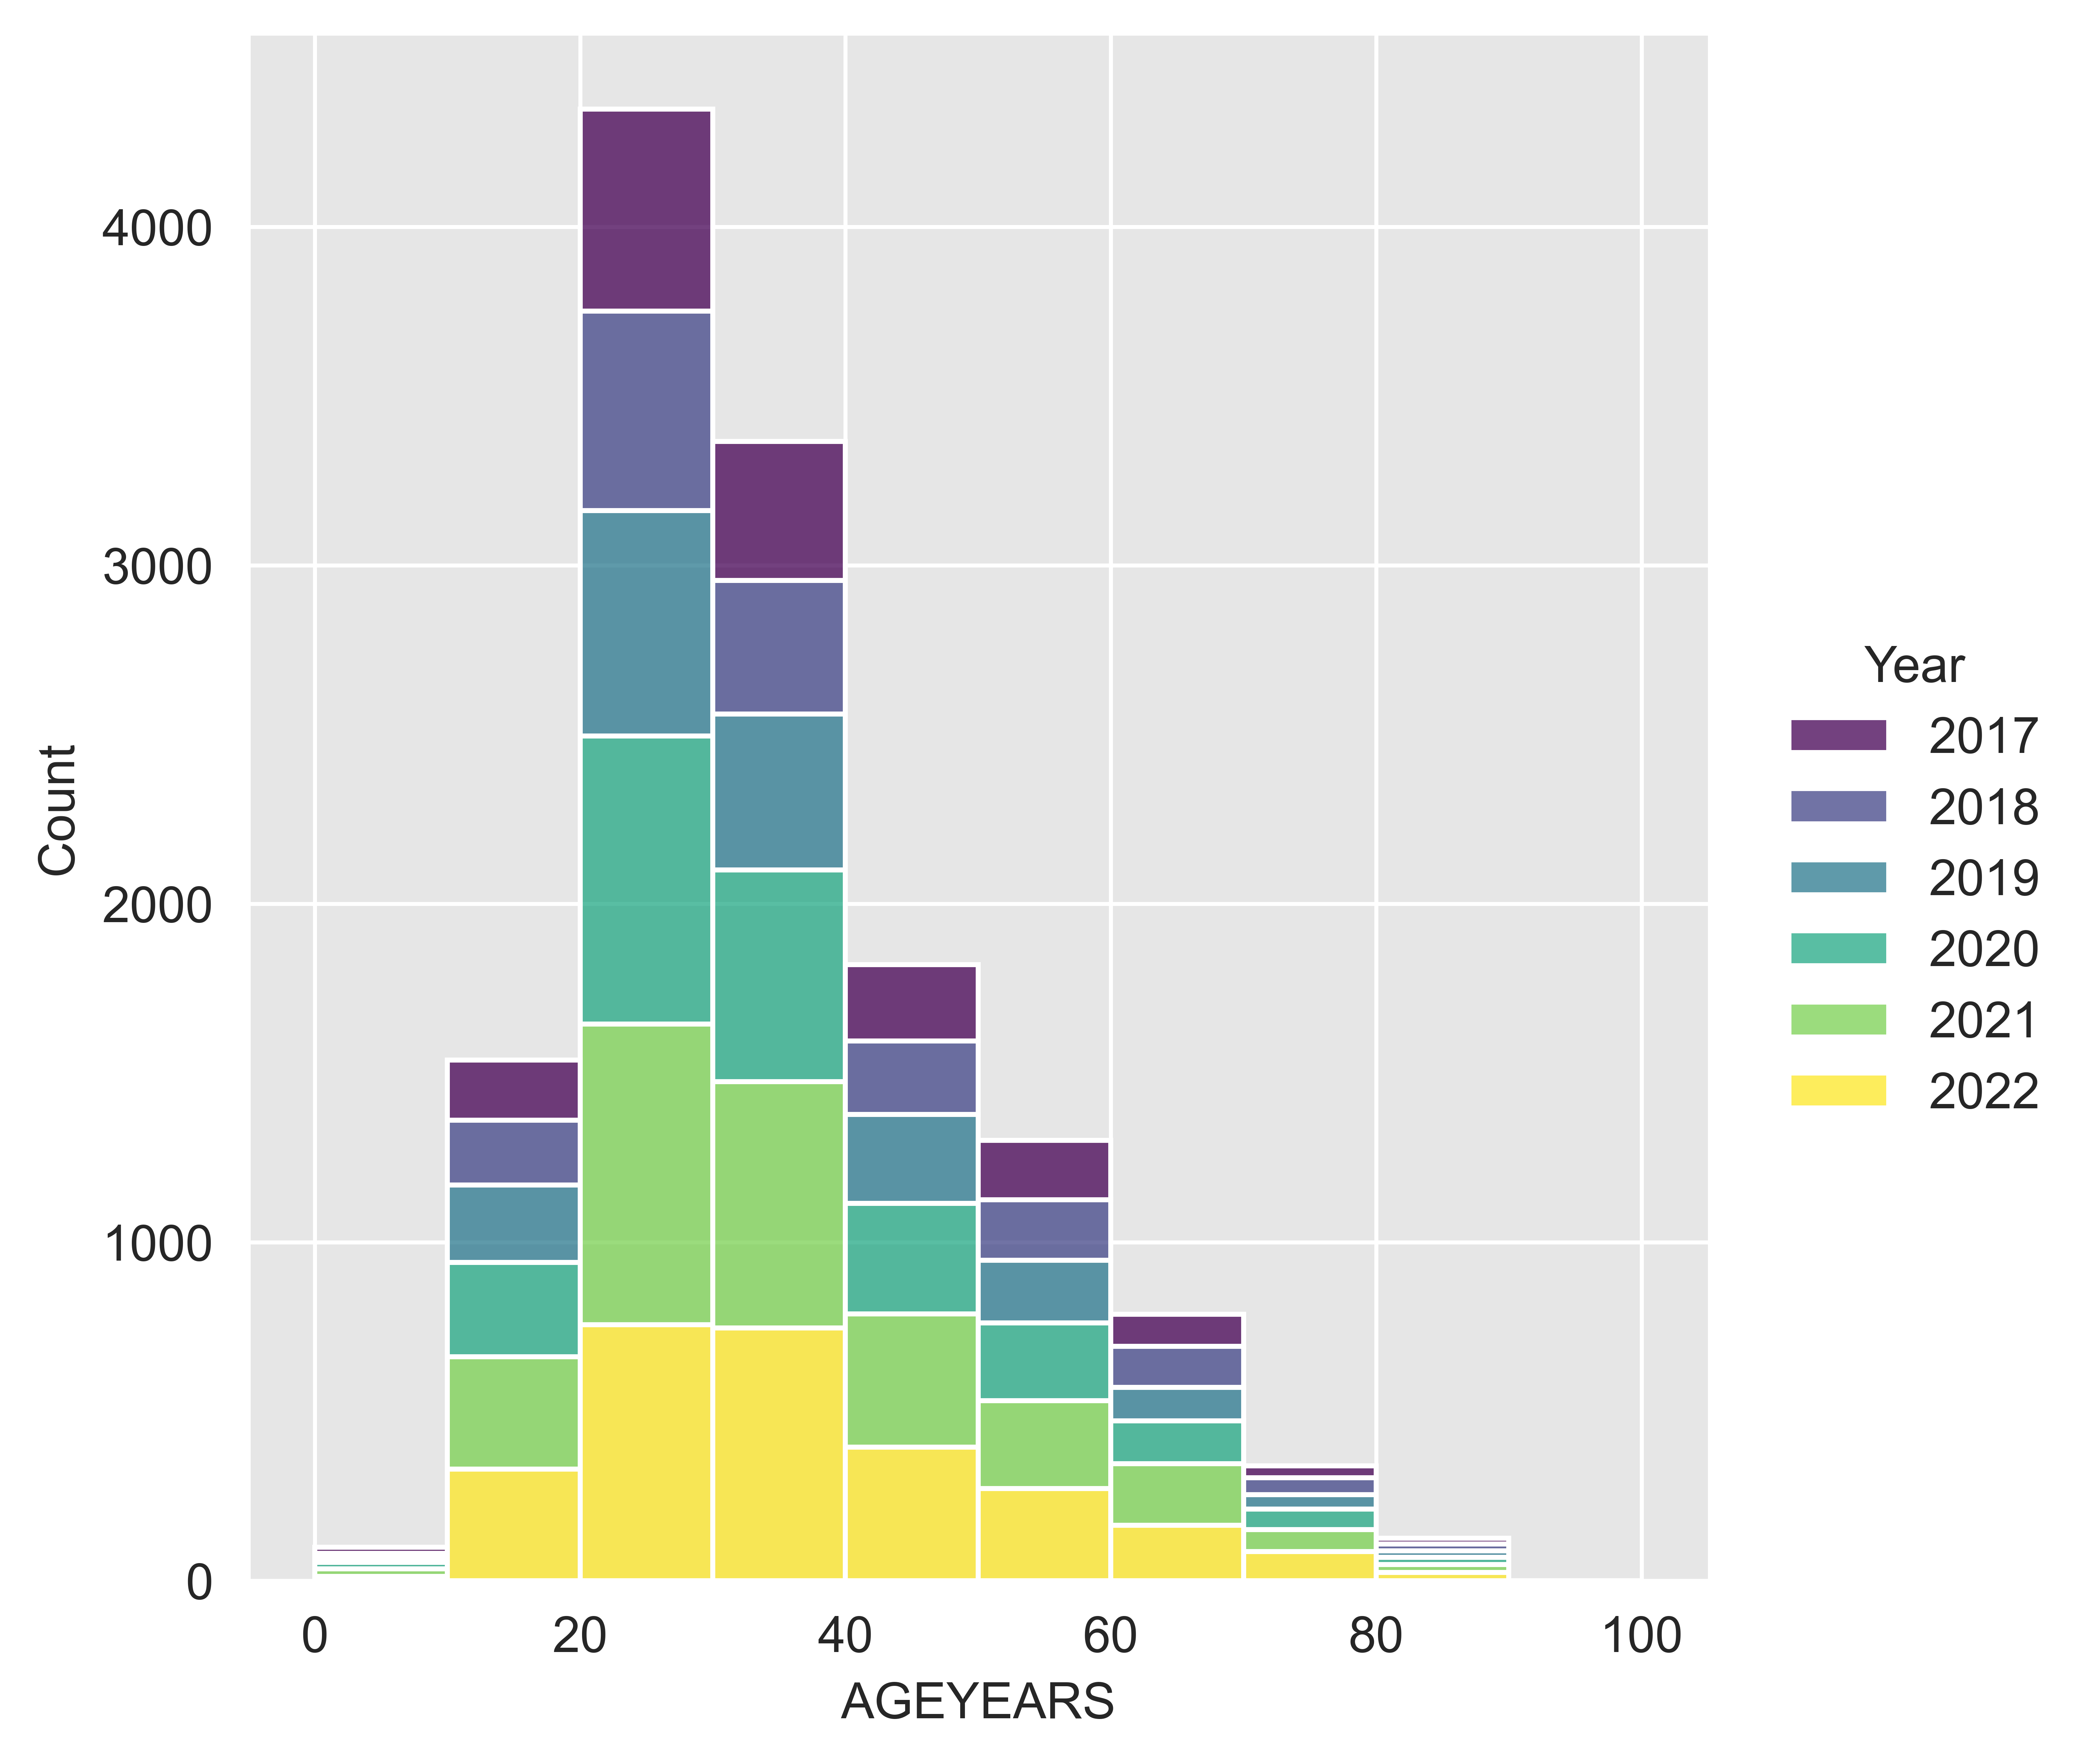

In [7]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='Year',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

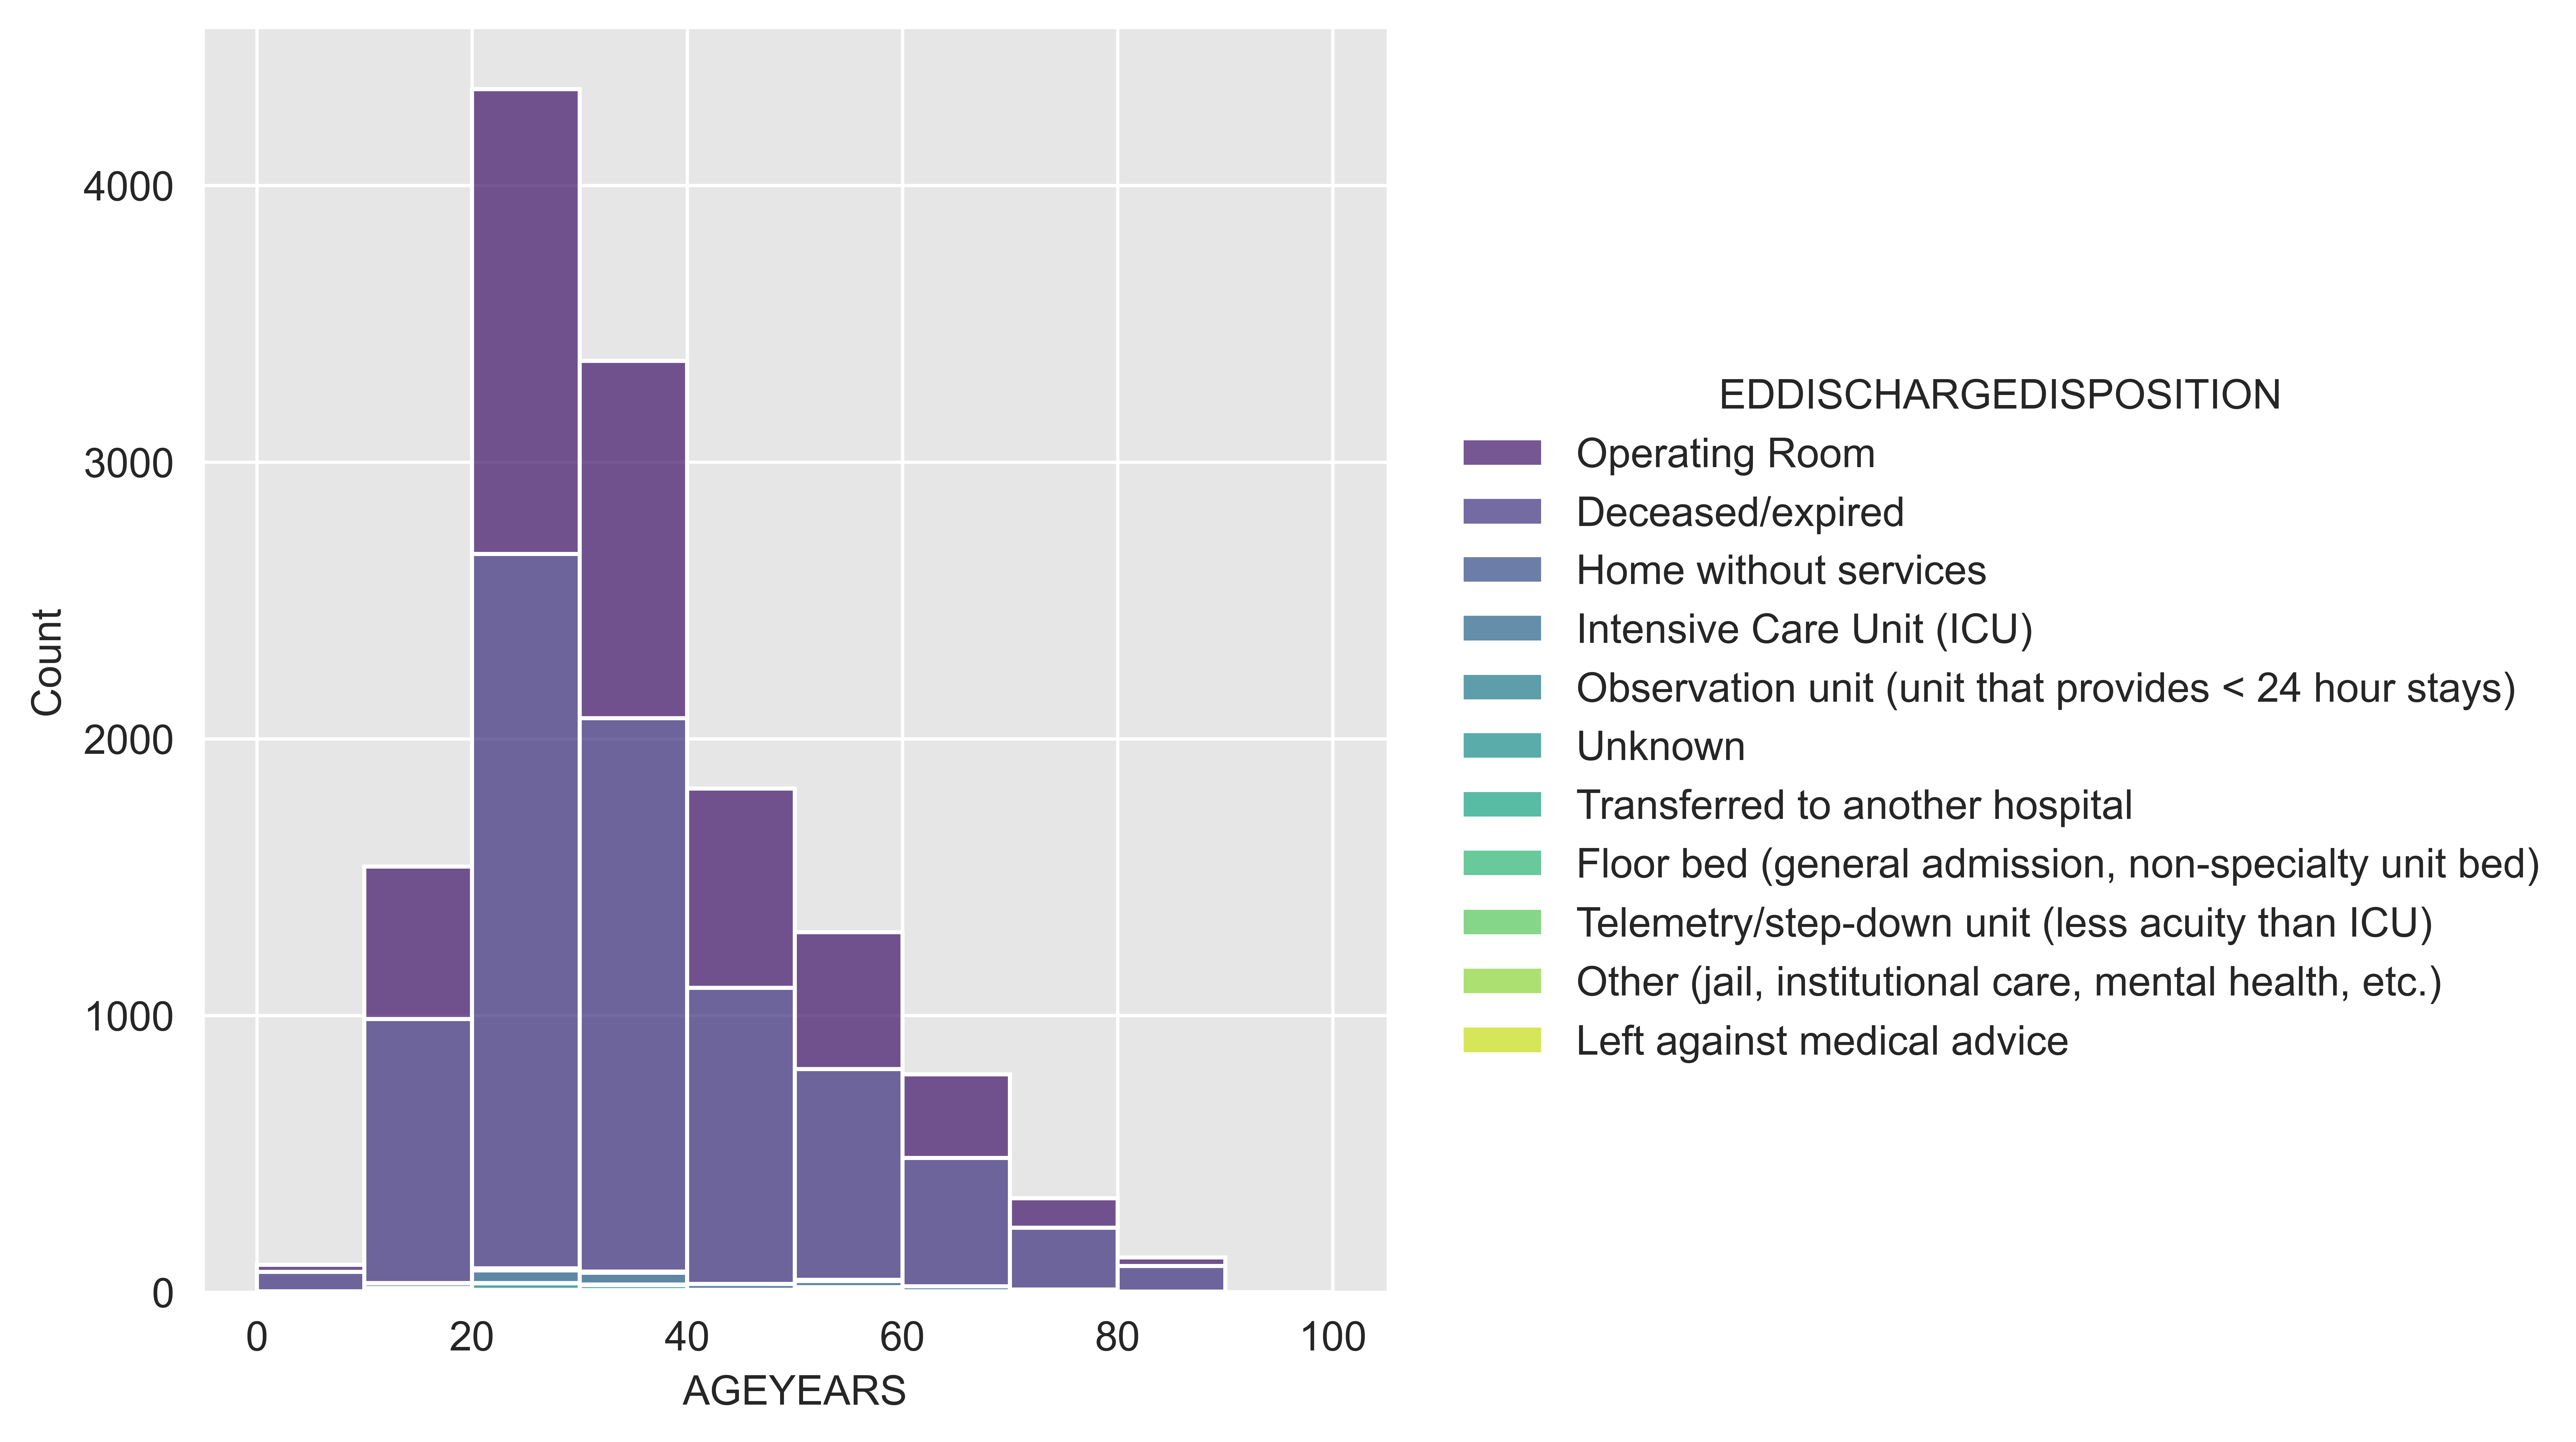

In [8]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='EDDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

In [9]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='HOSPDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

# Data about ICD Procedures (Includes **ALL** Procedures, not just the thoracomies but is only using thoracotomy patients)

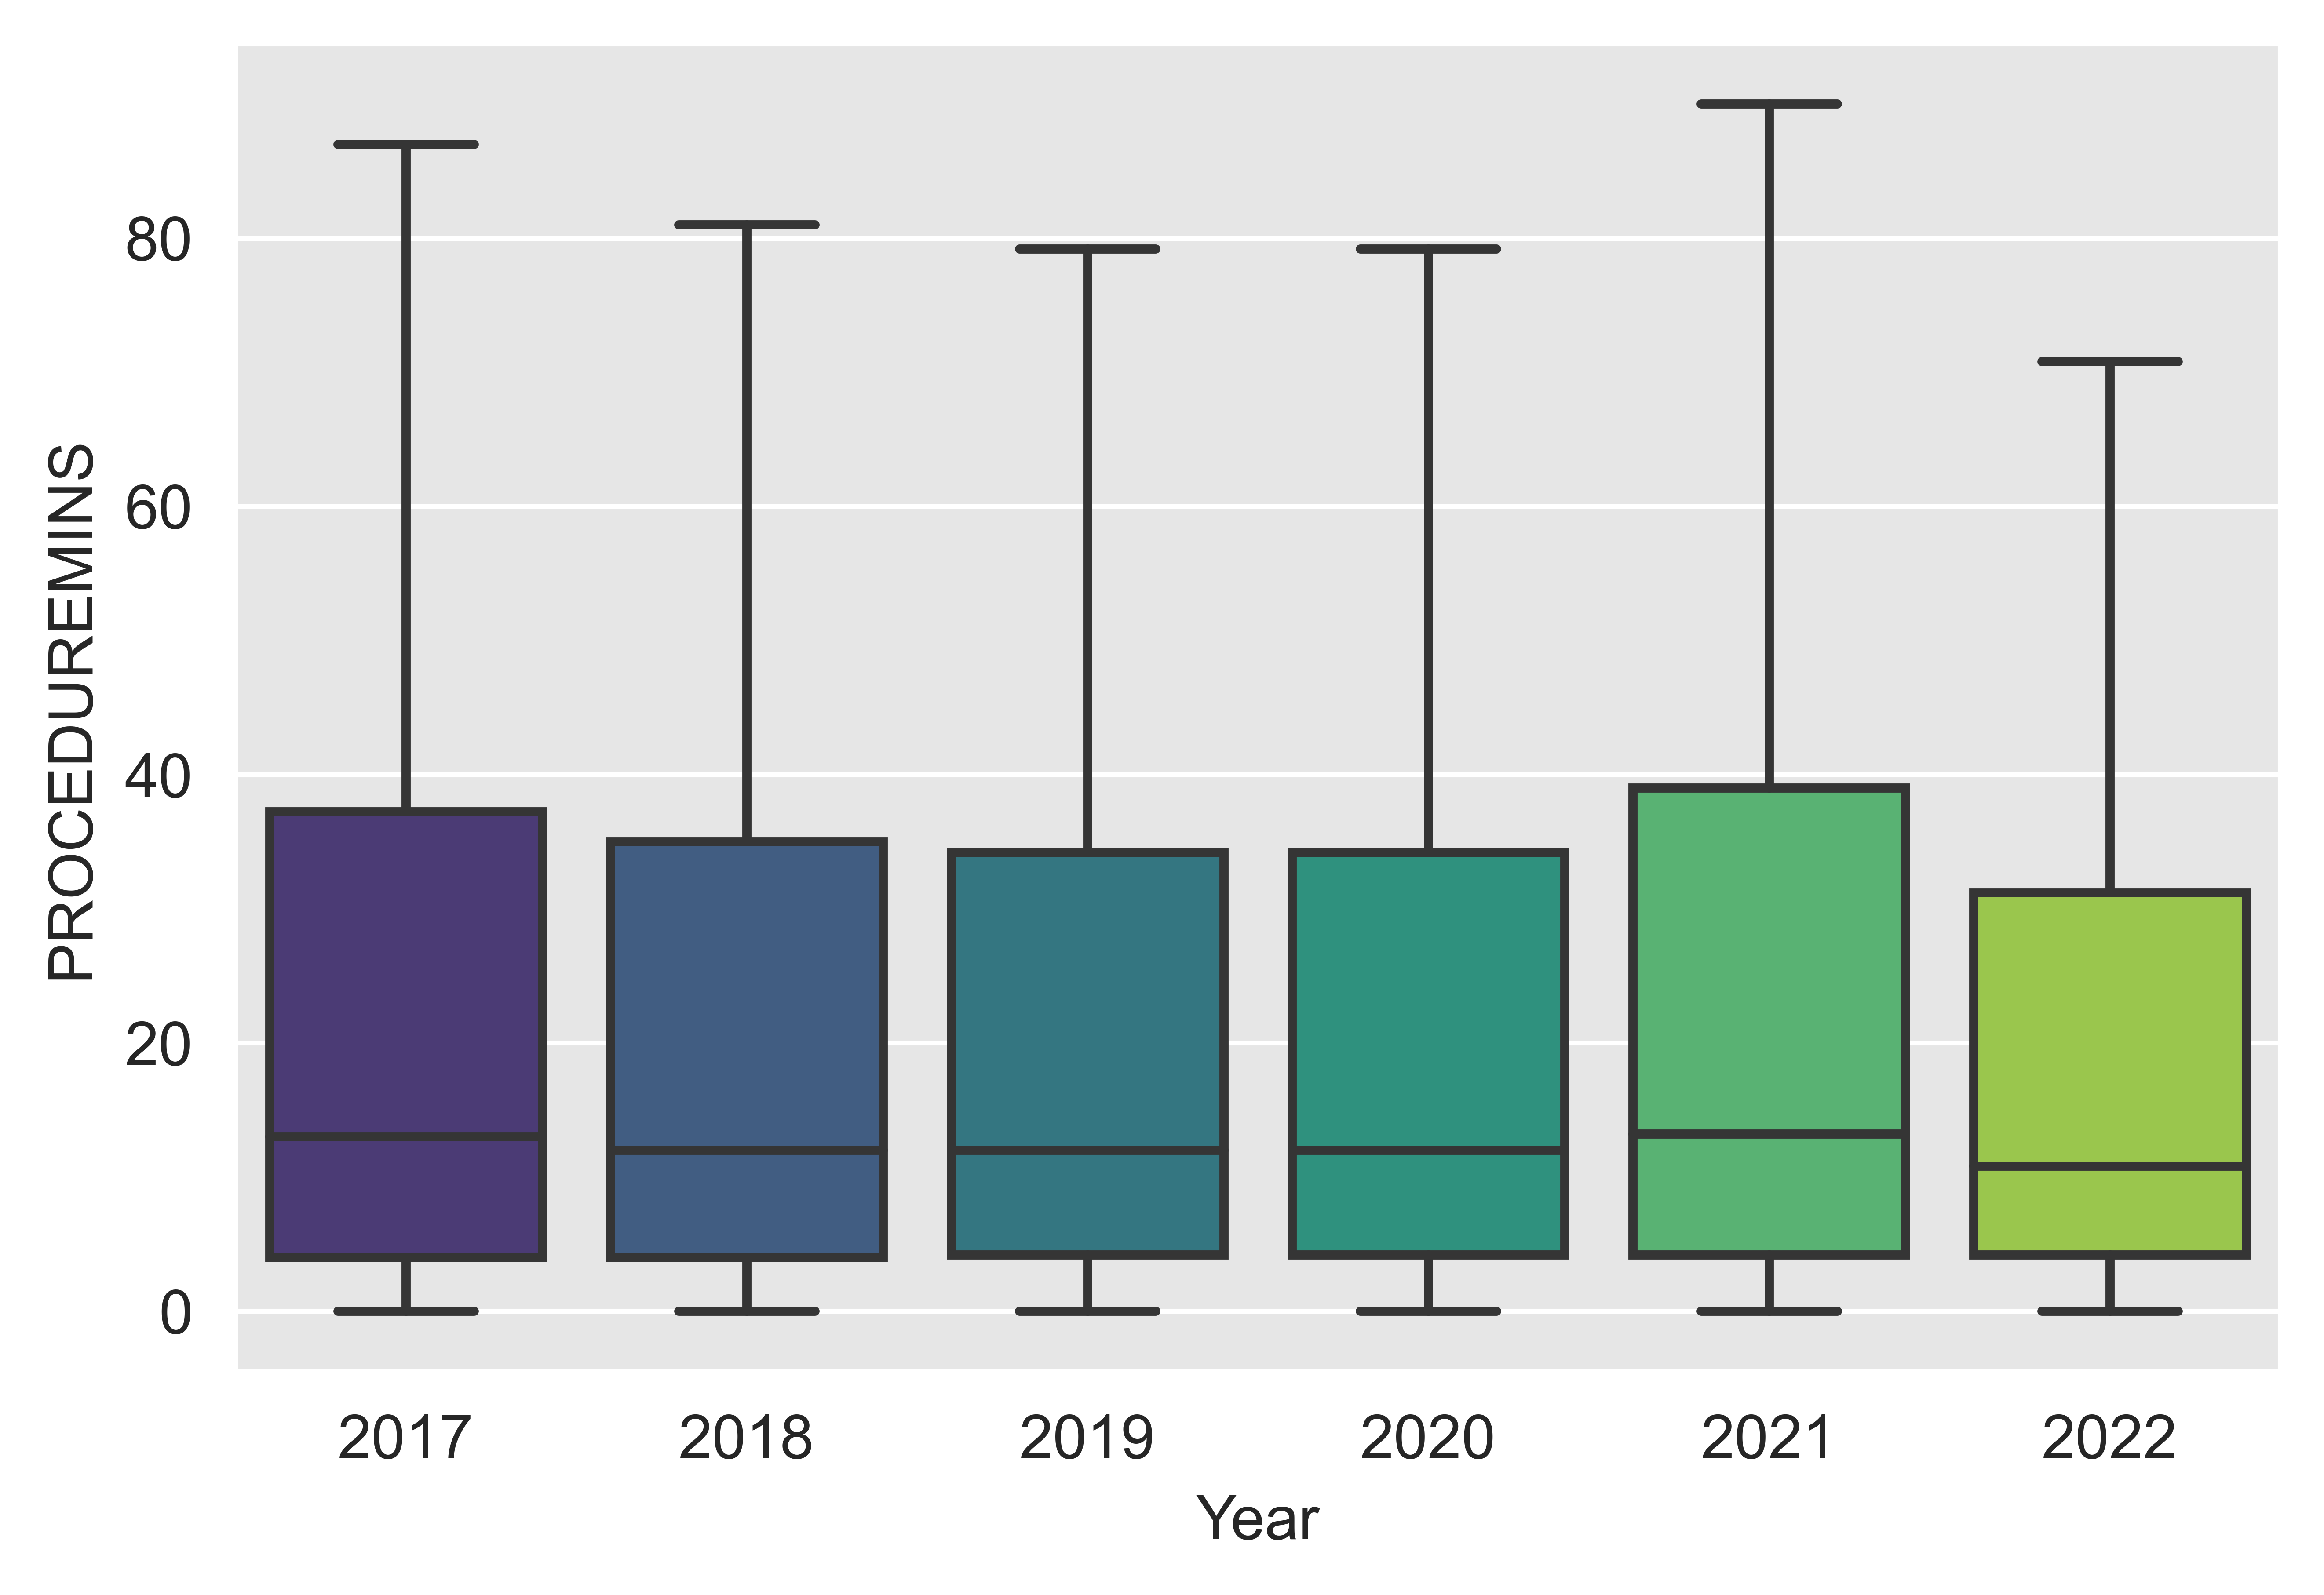

In [10]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

> This figure shows that a majority of patients who underwent a thoracotomy had their procedures performed within the first day (i.e. likely because most didn't survive to subsequent days)

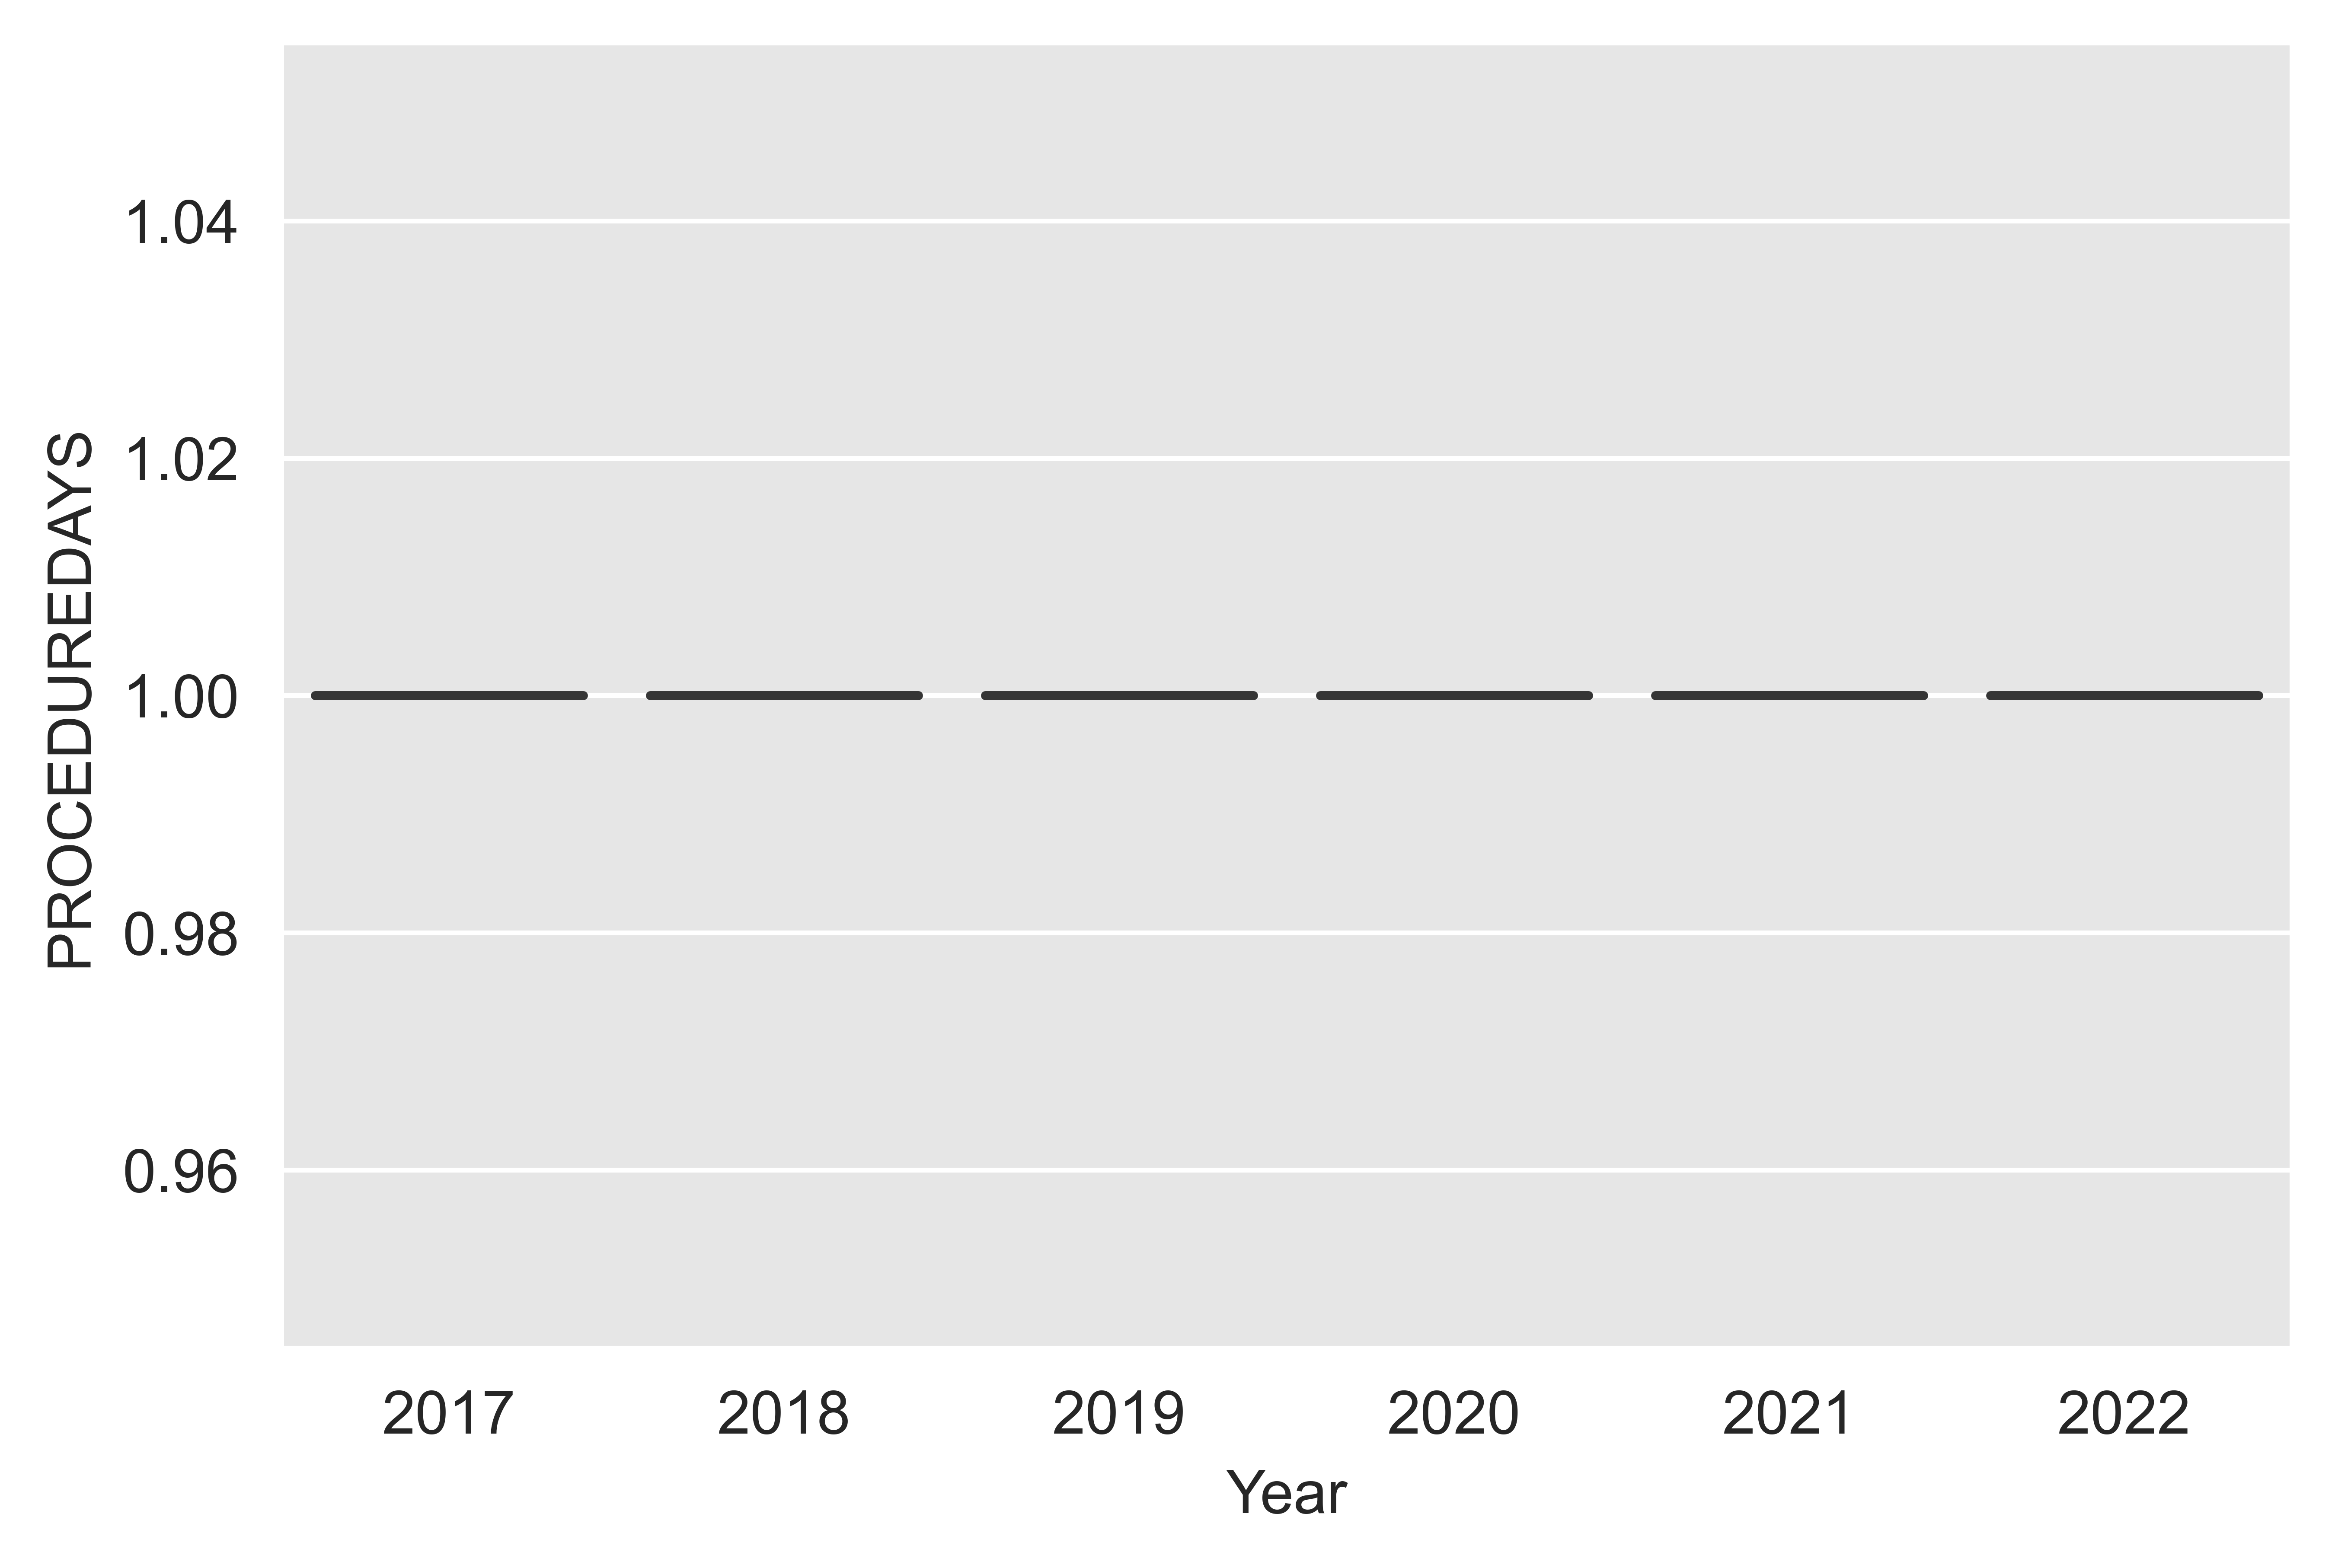

In [11]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

> If you include outliers from previous figure there are a numerous patients that underwent procedures outside of the first day, however, **ALL** of these are considered outliers in the data (i.e. surviving past the first day makes you an outlier)

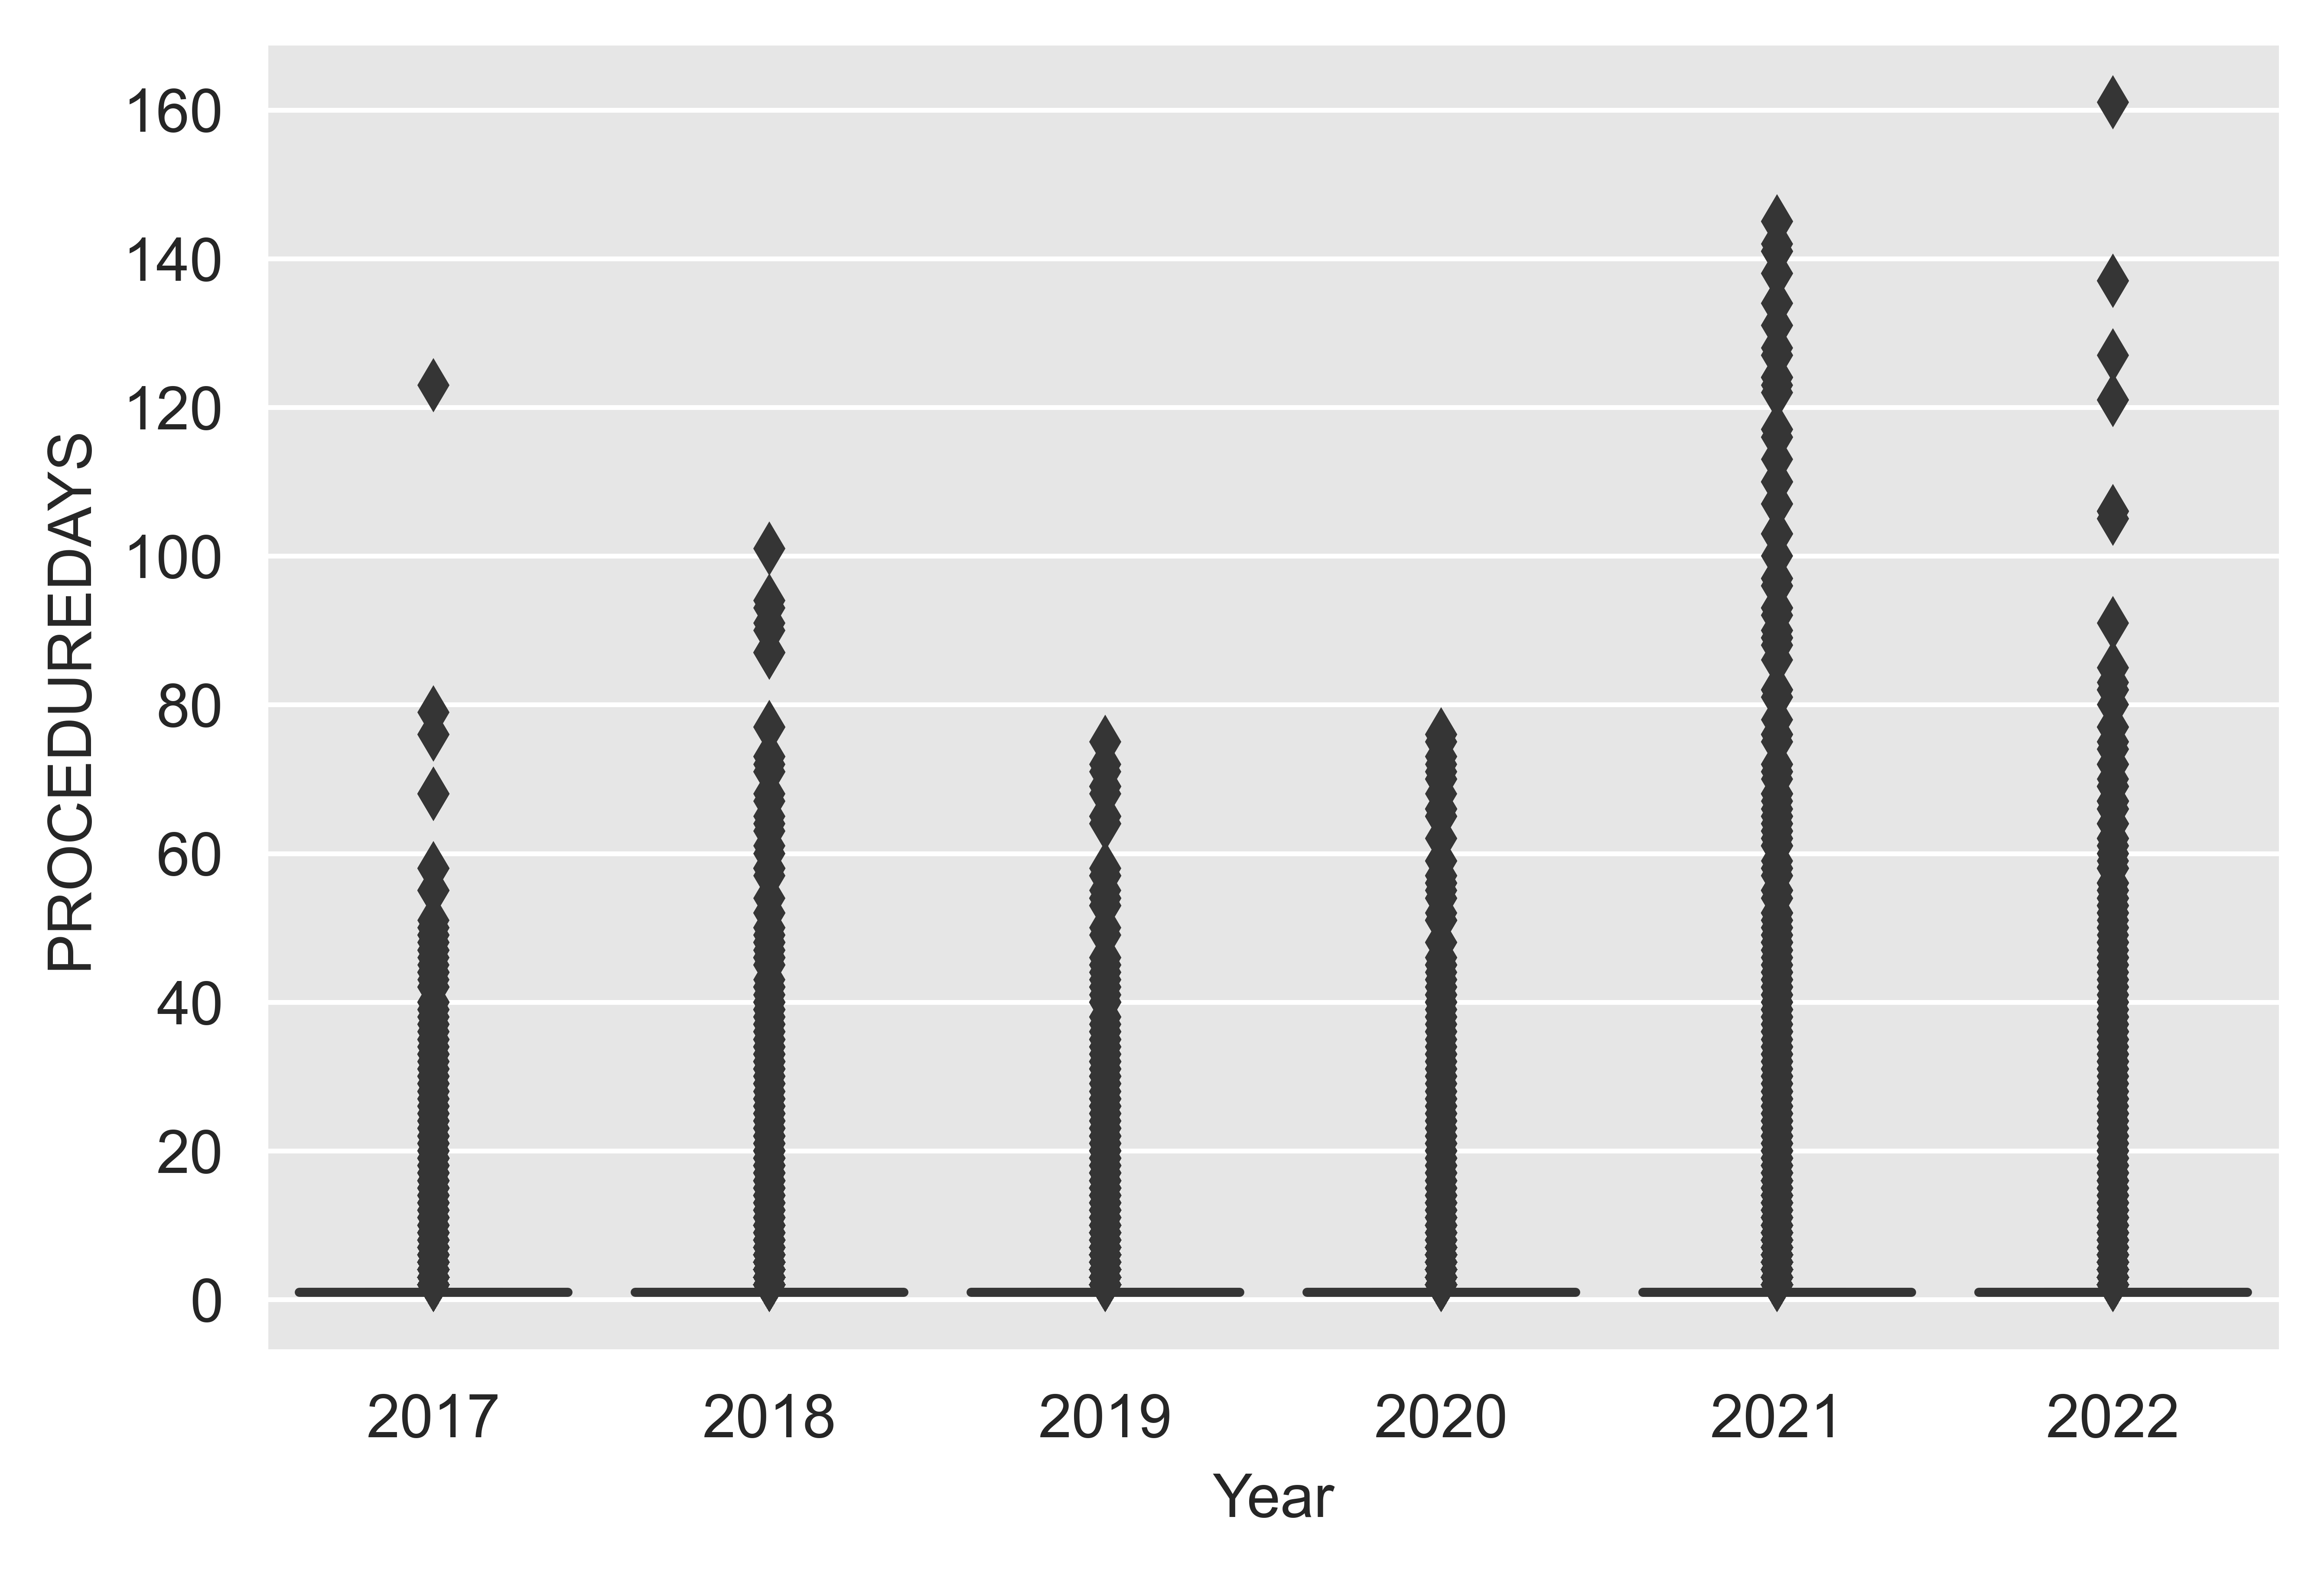

In [12]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

# Thoracotomy Patients, Only Looking at Procedures We Deemed Directly Thoracotomy Related

> A notable feature is that there are instances in which repeats of a procedure are performed in a relatively short period of time after the initial procedure as evidenced below in the displayed table. The population of patients used to generate this figure already have had patients filtered **OUT** that did not have their first thoracotomy/ adjacent procedure performed within the first **20 minutes**, therefore, any procedures performed outside of this window but are still in our list of thoracotomy procedures are from patients that **ALSO** had a thoracotomy/ related procedure within the first 20 minutes. This indicates that the filtering methods used above seemed to have worked fine and also brings up an intersting thing to explore which is why there are so many repeated procedures for the same individual within this first hour or so (i.e. are these procedures that were started in the ED and then resumed/ reinvestigated in the OR, did the patient recover and then deteriorate again prompting reinspection of the heart etc).

INC_KEY                                  ICDPROCEDURECODE  \
6   170000020367                       Repair Heart, Open Approach   
12  170000046992                       Repair Heart, Open Approach   
22  170000046992                       Repair Heart, Open Approach   
30  170000057961  Inspection of Left Pleural Cavity, Open Approach   
38  170000021290                       Repair Heart, Open Approach   

    PROCEDUREMINS  PROCEDUREDAYS  Year  
6            12.0            1.0  2017  
12           13.0            1.0  2017  
22           36.0            1.0  2017  
30            3.0            1.0  2017  
38           11.0            1.0  2017

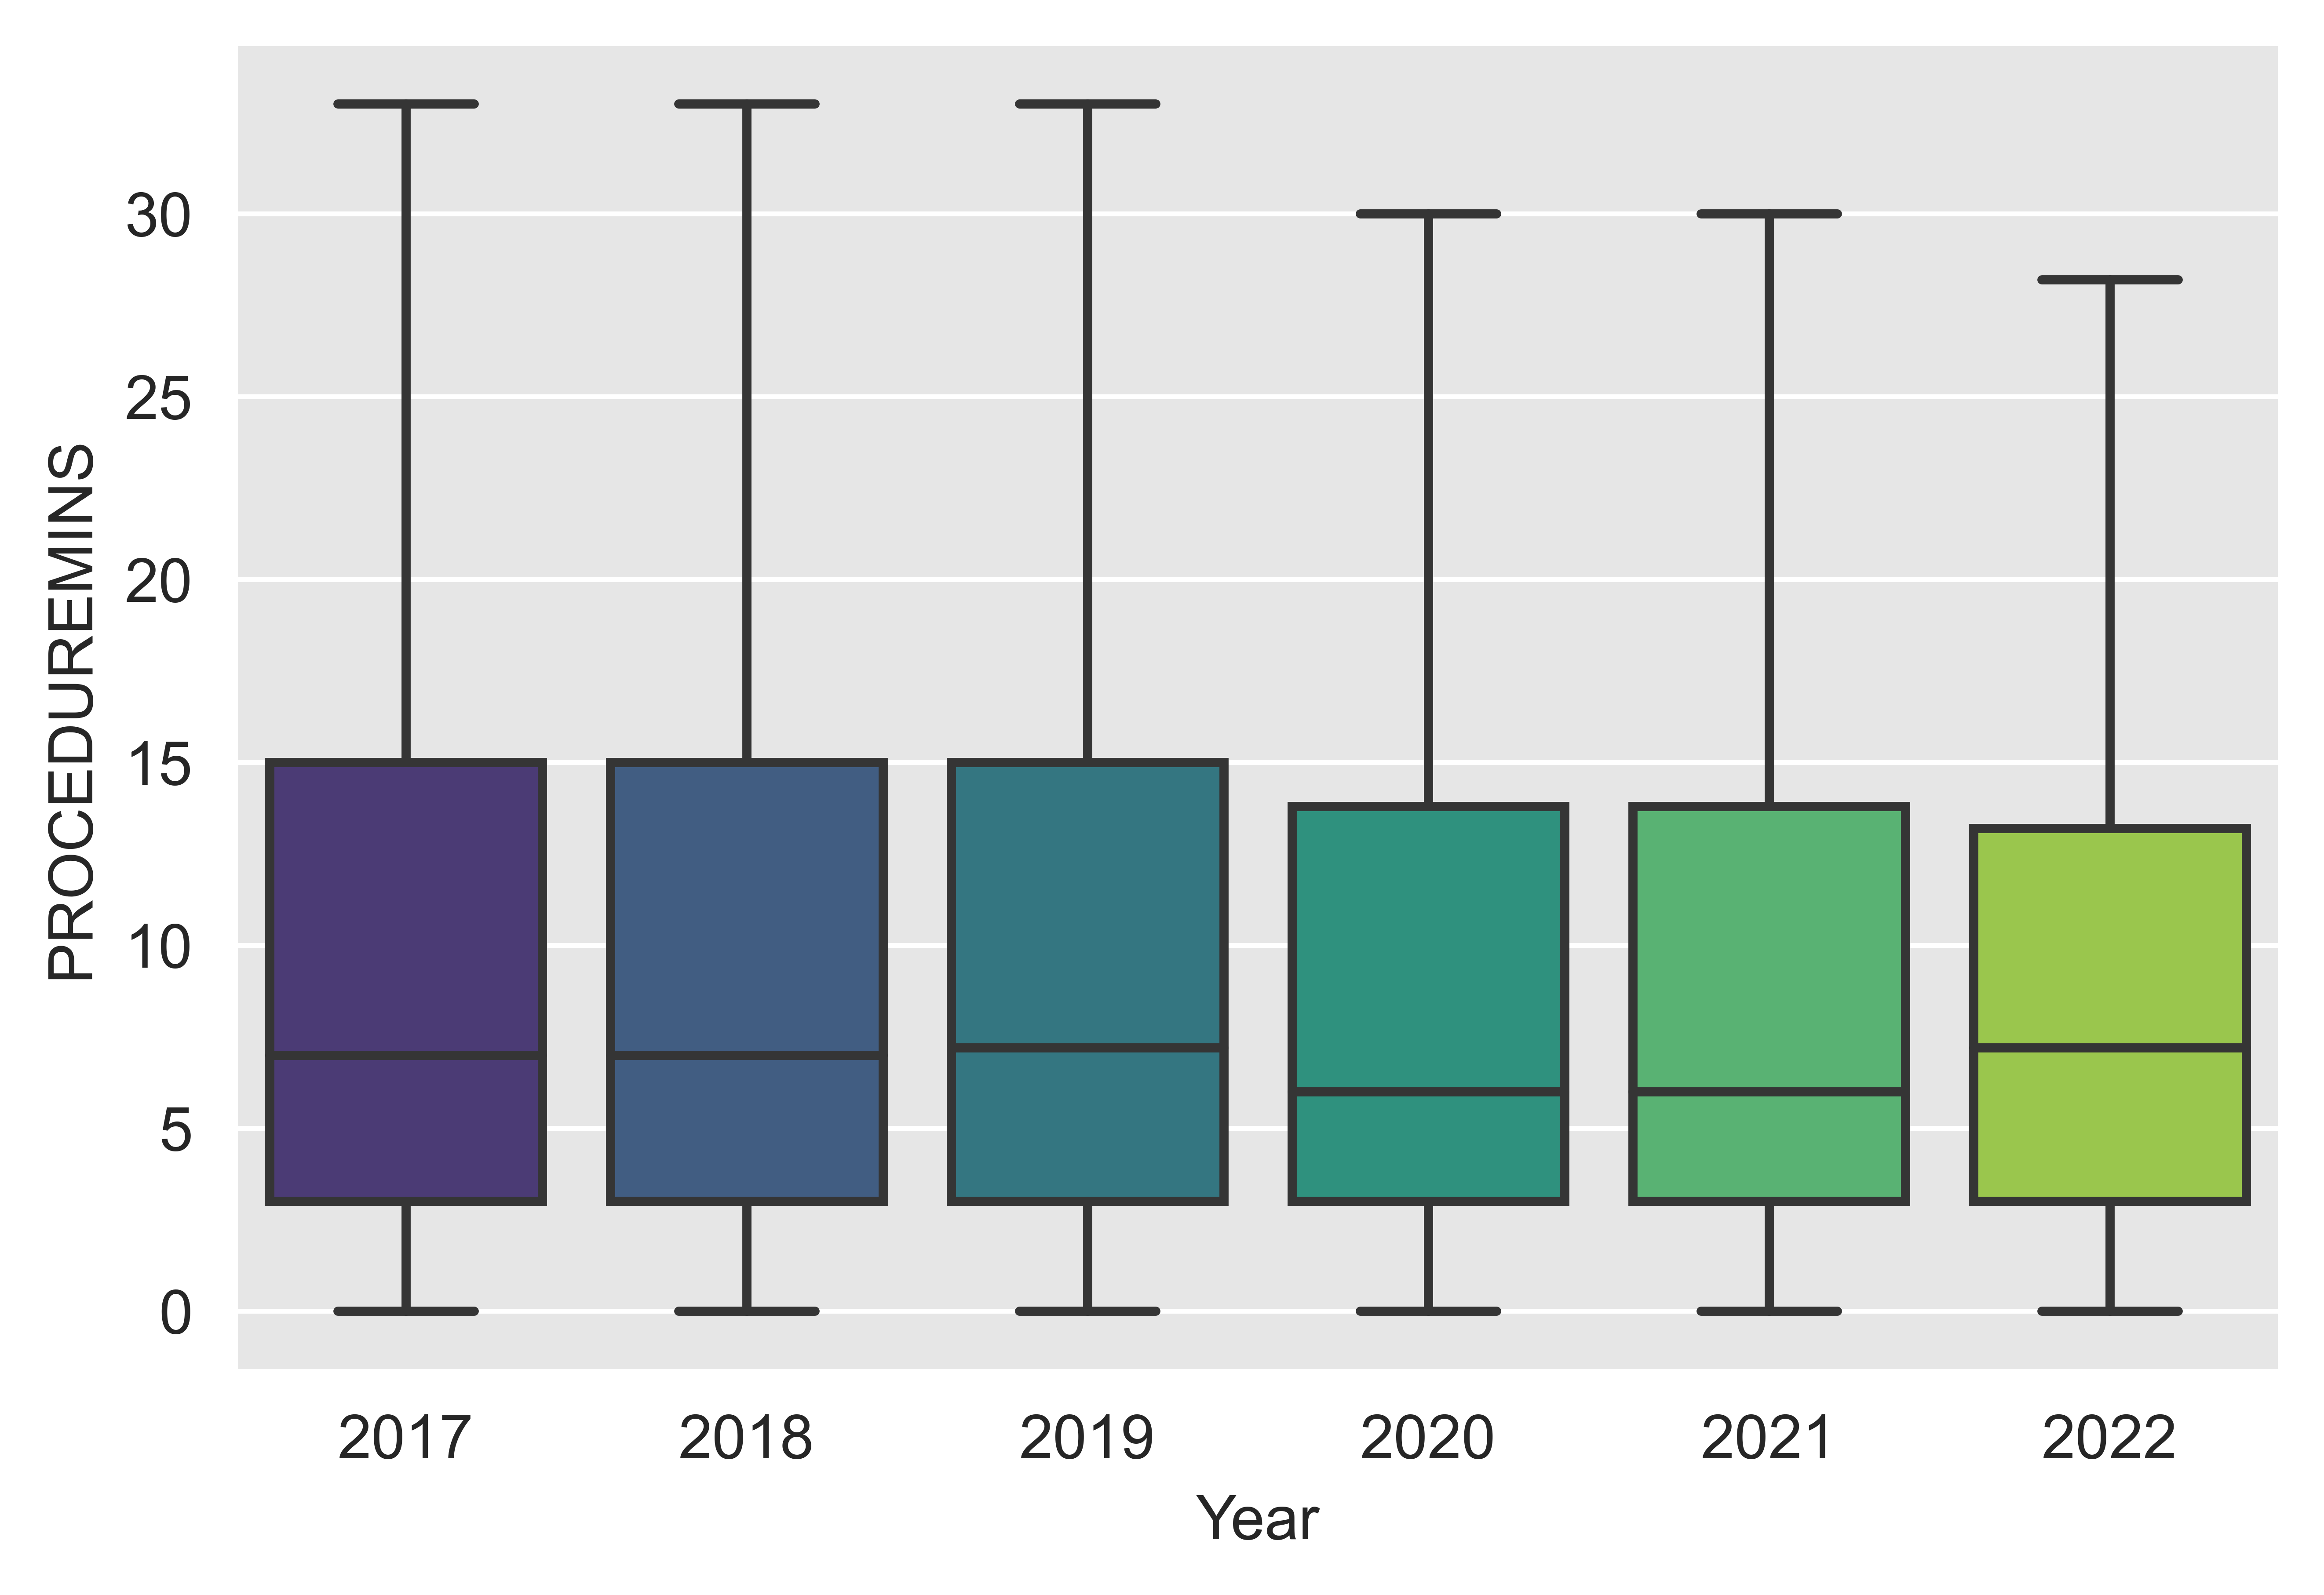

In [13]:
thoracotomy_translated = pd.DataFrame(thoracotomy_codes, columns=['Codes'])
thoracotomy_translated = thoracotomy_translated['Codes'].replace(procedure_dict)
thoracotomy_timing = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['ICDPROCEDURECODE'].isin(thoracotomy_translated)]
display(thoracotomy_timing.head())

mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

> The below figure is obviously uninteresting but validates that the filtering protocols in previous steps at the very least limited the procedures to the thoracotomies performed on the same day as arrival to the ED.

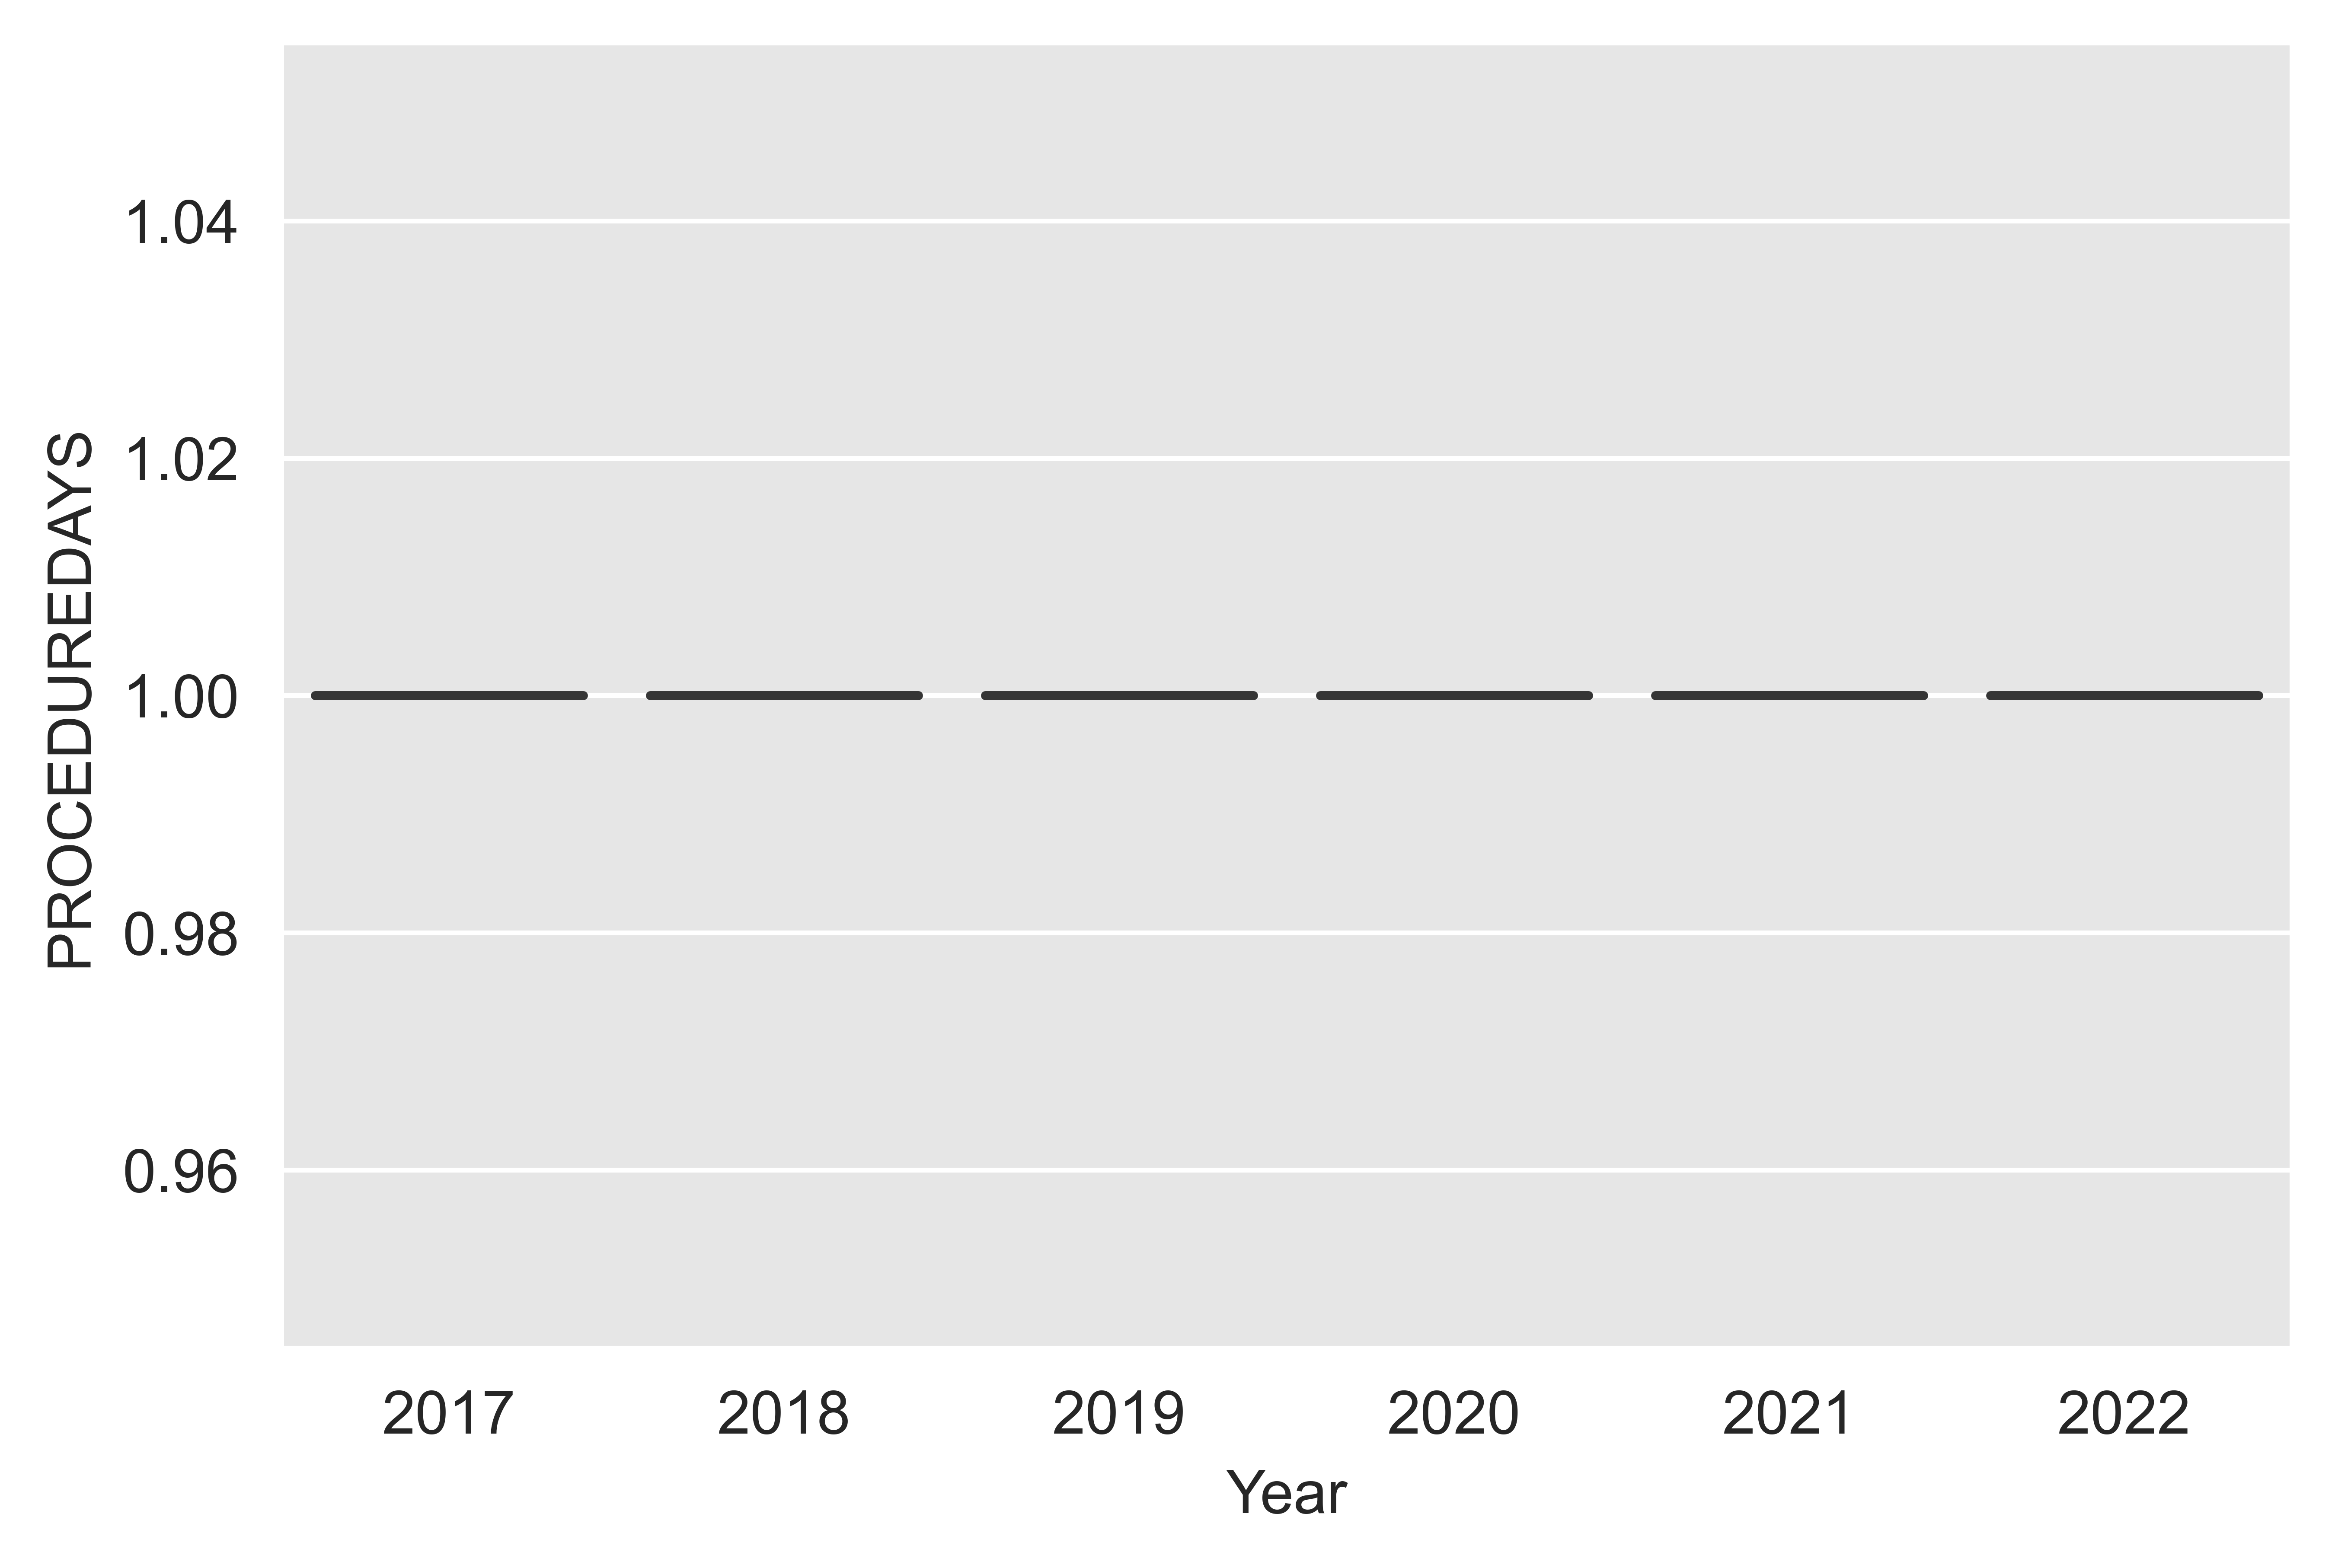

In [14]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

> Of the people who underwent an initial thoracotomy within the first 20 minutes, the vast majority underwent these procedures within the first day. As demonstrated by the presence of the below outliers, there are patients who underwent subsequent thoracotomy/ related procedures following the initial thoracotomy/ related procedure.

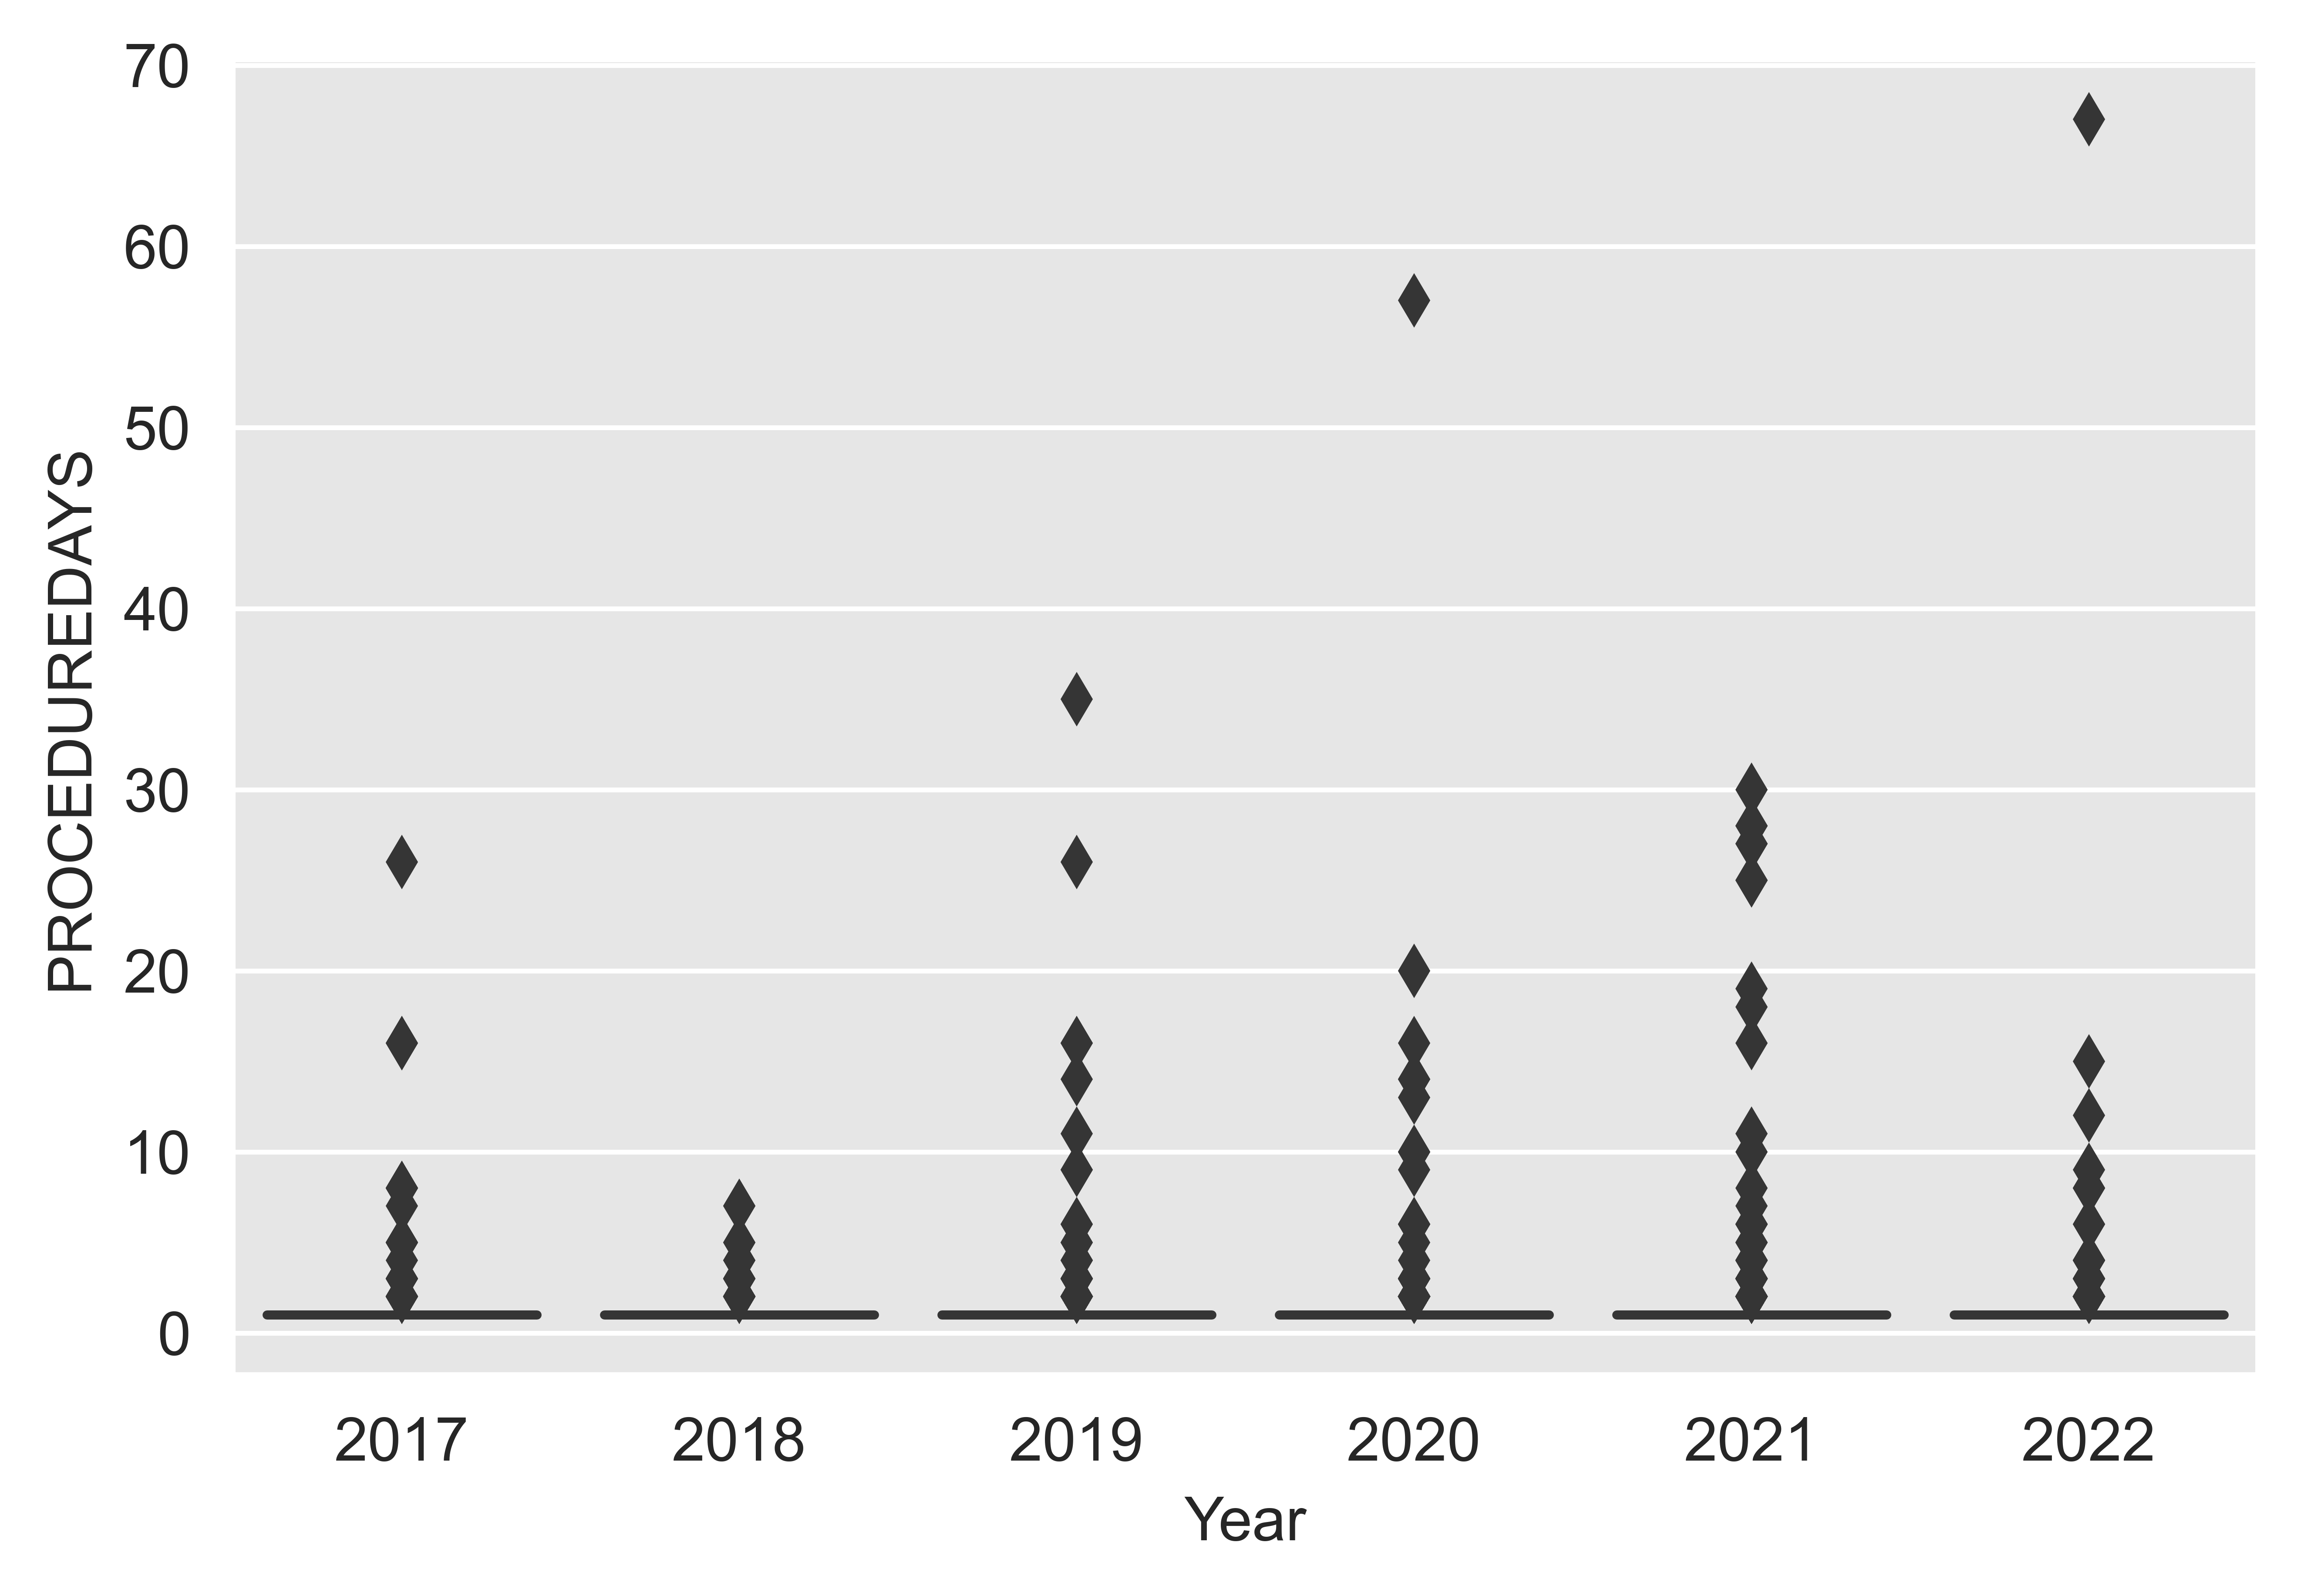

In [15]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=thoracotomy_timing,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

# Create Mortality Statistics
## Create `DataFrame` of Mortality by `Year` and `Mechanism`

In [16]:
mortality_year_table = pd.DataFrame(columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
years = range(2017, 2023) # set to year 2016 for max with this part of pipeline
for year in years:
    year_df = TRAUMA_all_df[TRAUMA_all_df['Year'] == year]
    penetrating_df = year_df[year_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = year_df[year_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[year, mortality_pen_p, 'Penetrating', np.shape(year_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    final_blunt_df = pd.DataFrame([[year, mortality_blunt_p, 'Blunt', np.shape(year_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    mortality_year_table = pd.concat([mortality_year_table, combined_df])
mortality_year_table['Mortality %'] = mortality_year_table['Mortality %'].astype(float)
mortality_year_table['Year'] = mortality_year_table['Year'].astype(int)
display(mortality_year_table)

Year  Mortality %          MOI  \
0  2017    89.727127  Penetrating   
1  2017    95.841210        Blunt   
0  2018    92.537313  Penetrating   
1  2018    94.633274        Blunt   
0  2019    92.141312  Penetrating   
1  2019    96.698113        Blunt   
0  2020    92.883895  Penetrating   
1  2020    95.518207        Blunt   
0  2021    92.443572  Penetrating   
1  2021    94.235033        Blunt   
0  2022    93.404826  Penetrating   
1  2022    96.629213        Blunt   

  Thoracotomies Performed (Year Total for All MOI)  
0                                             1775  
1                                             1775  
0                                             1832  
1                                             1832  
0                                             2023  
1                                             2023  
0                                             2583  
1                                             2583  
0                                             2940  
1                                             2940  
0                                             2844  
1                                             2844

## Plot Year vs. Mortality

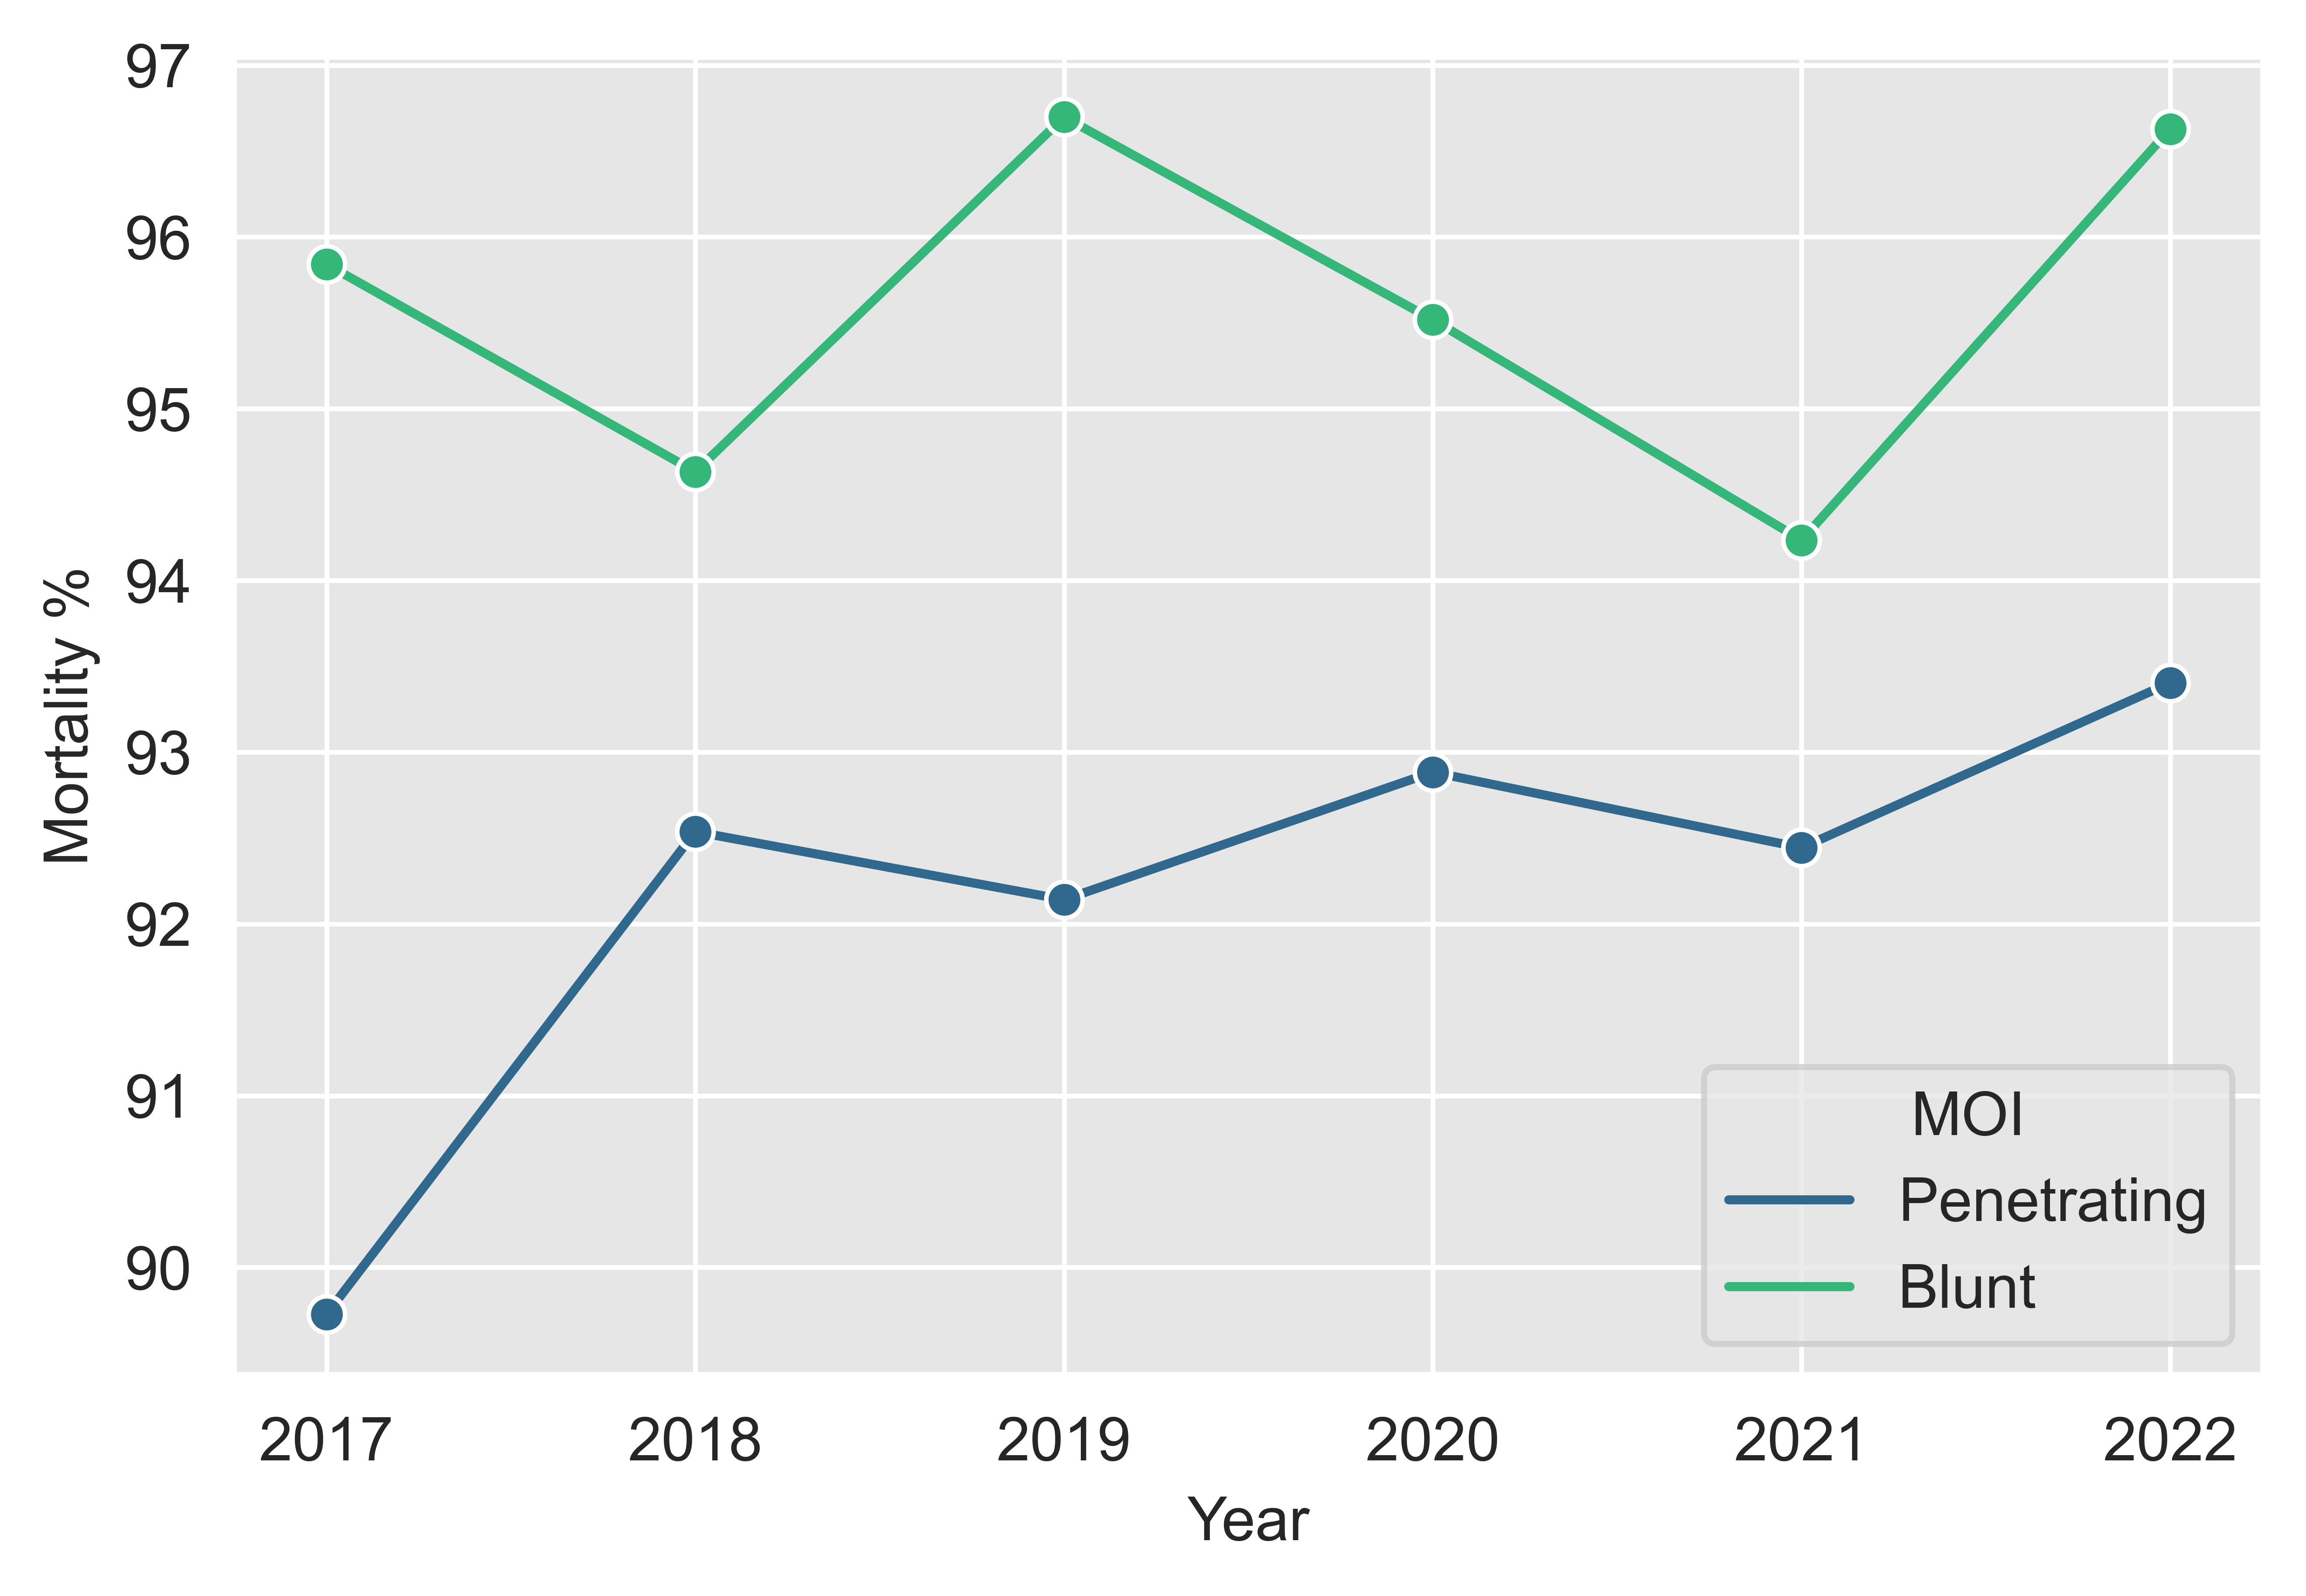

In [46]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_year_table,
               y='Mortality %',
               x='Year',
               hue='MOI',
               palette='viridis',
               marker='o')
tick_labels = np.arange(mortality_year_table['Year'].min(), mortality_year_table['Year'].max() + 1)
g.set_xticks(tick_labels)
g.set_xticklabels(tick_labels.astype(int))
plt.show()

## Create `DataFrame` of Mortality by `Age` and `Trauma Type`

In [18]:
mortality_age_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
age_ranges = range(0, 110, 10)

for age_range in age_ranges:
    age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range+1) & (TRAUMA_all_df['AGEYEARS'] <= age_range+10)]
    penetrating_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Penetrating'])]
    if np.shape(penetrating_df)[0] == 0:
        continue
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Blunt'])]
    if np.shape(blunt_df)[0] == 0:
        continue
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_blunt_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
    mortality_age_table = pd.concat([mortality_age_table, combined_df])
mortality_age_table['Mortality %'] = mortality_age_table['Mortality %'].astype(float)
mortality_age_table['Age Range'] = mortality_age_table['Age Range'].astype(str)
display(mortality_age_table)

Mortality %  Trauma Type Age Range # of Cases
0   100.000000  Penetrating    1 - 10         49
1    94.736842        Blunt    1 - 10         57
0    92.522180  Penetrating   11 - 20       1578
1    94.957983        Blunt   11 - 20        357
0    92.035398  Penetrating   21 - 30       3164
1    94.851259        Blunt   21 - 30        874
0    91.795127  Penetrating   31 - 40       2011
1    94.972067        Blunt   31 - 40        716
0    91.769547  Penetrating   41 - 50        972
1    95.281307        Blunt   41 - 50        551
0    91.287129  Penetrating   51 - 60        505
1    95.352840        Blunt   51 - 60        581
0    93.956044  Penetrating   61 - 70        182
1    97.441860        Blunt   61 - 70        430
0    98.245614  Penetrating   71 - 80         57
1    99.043062        Blunt   71 - 80        209
0   100.000000  Penetrating   81 - 90         13
1    97.500000        Blunt   81 - 90         80

## Plot Age vs. Mortality `Barplot`

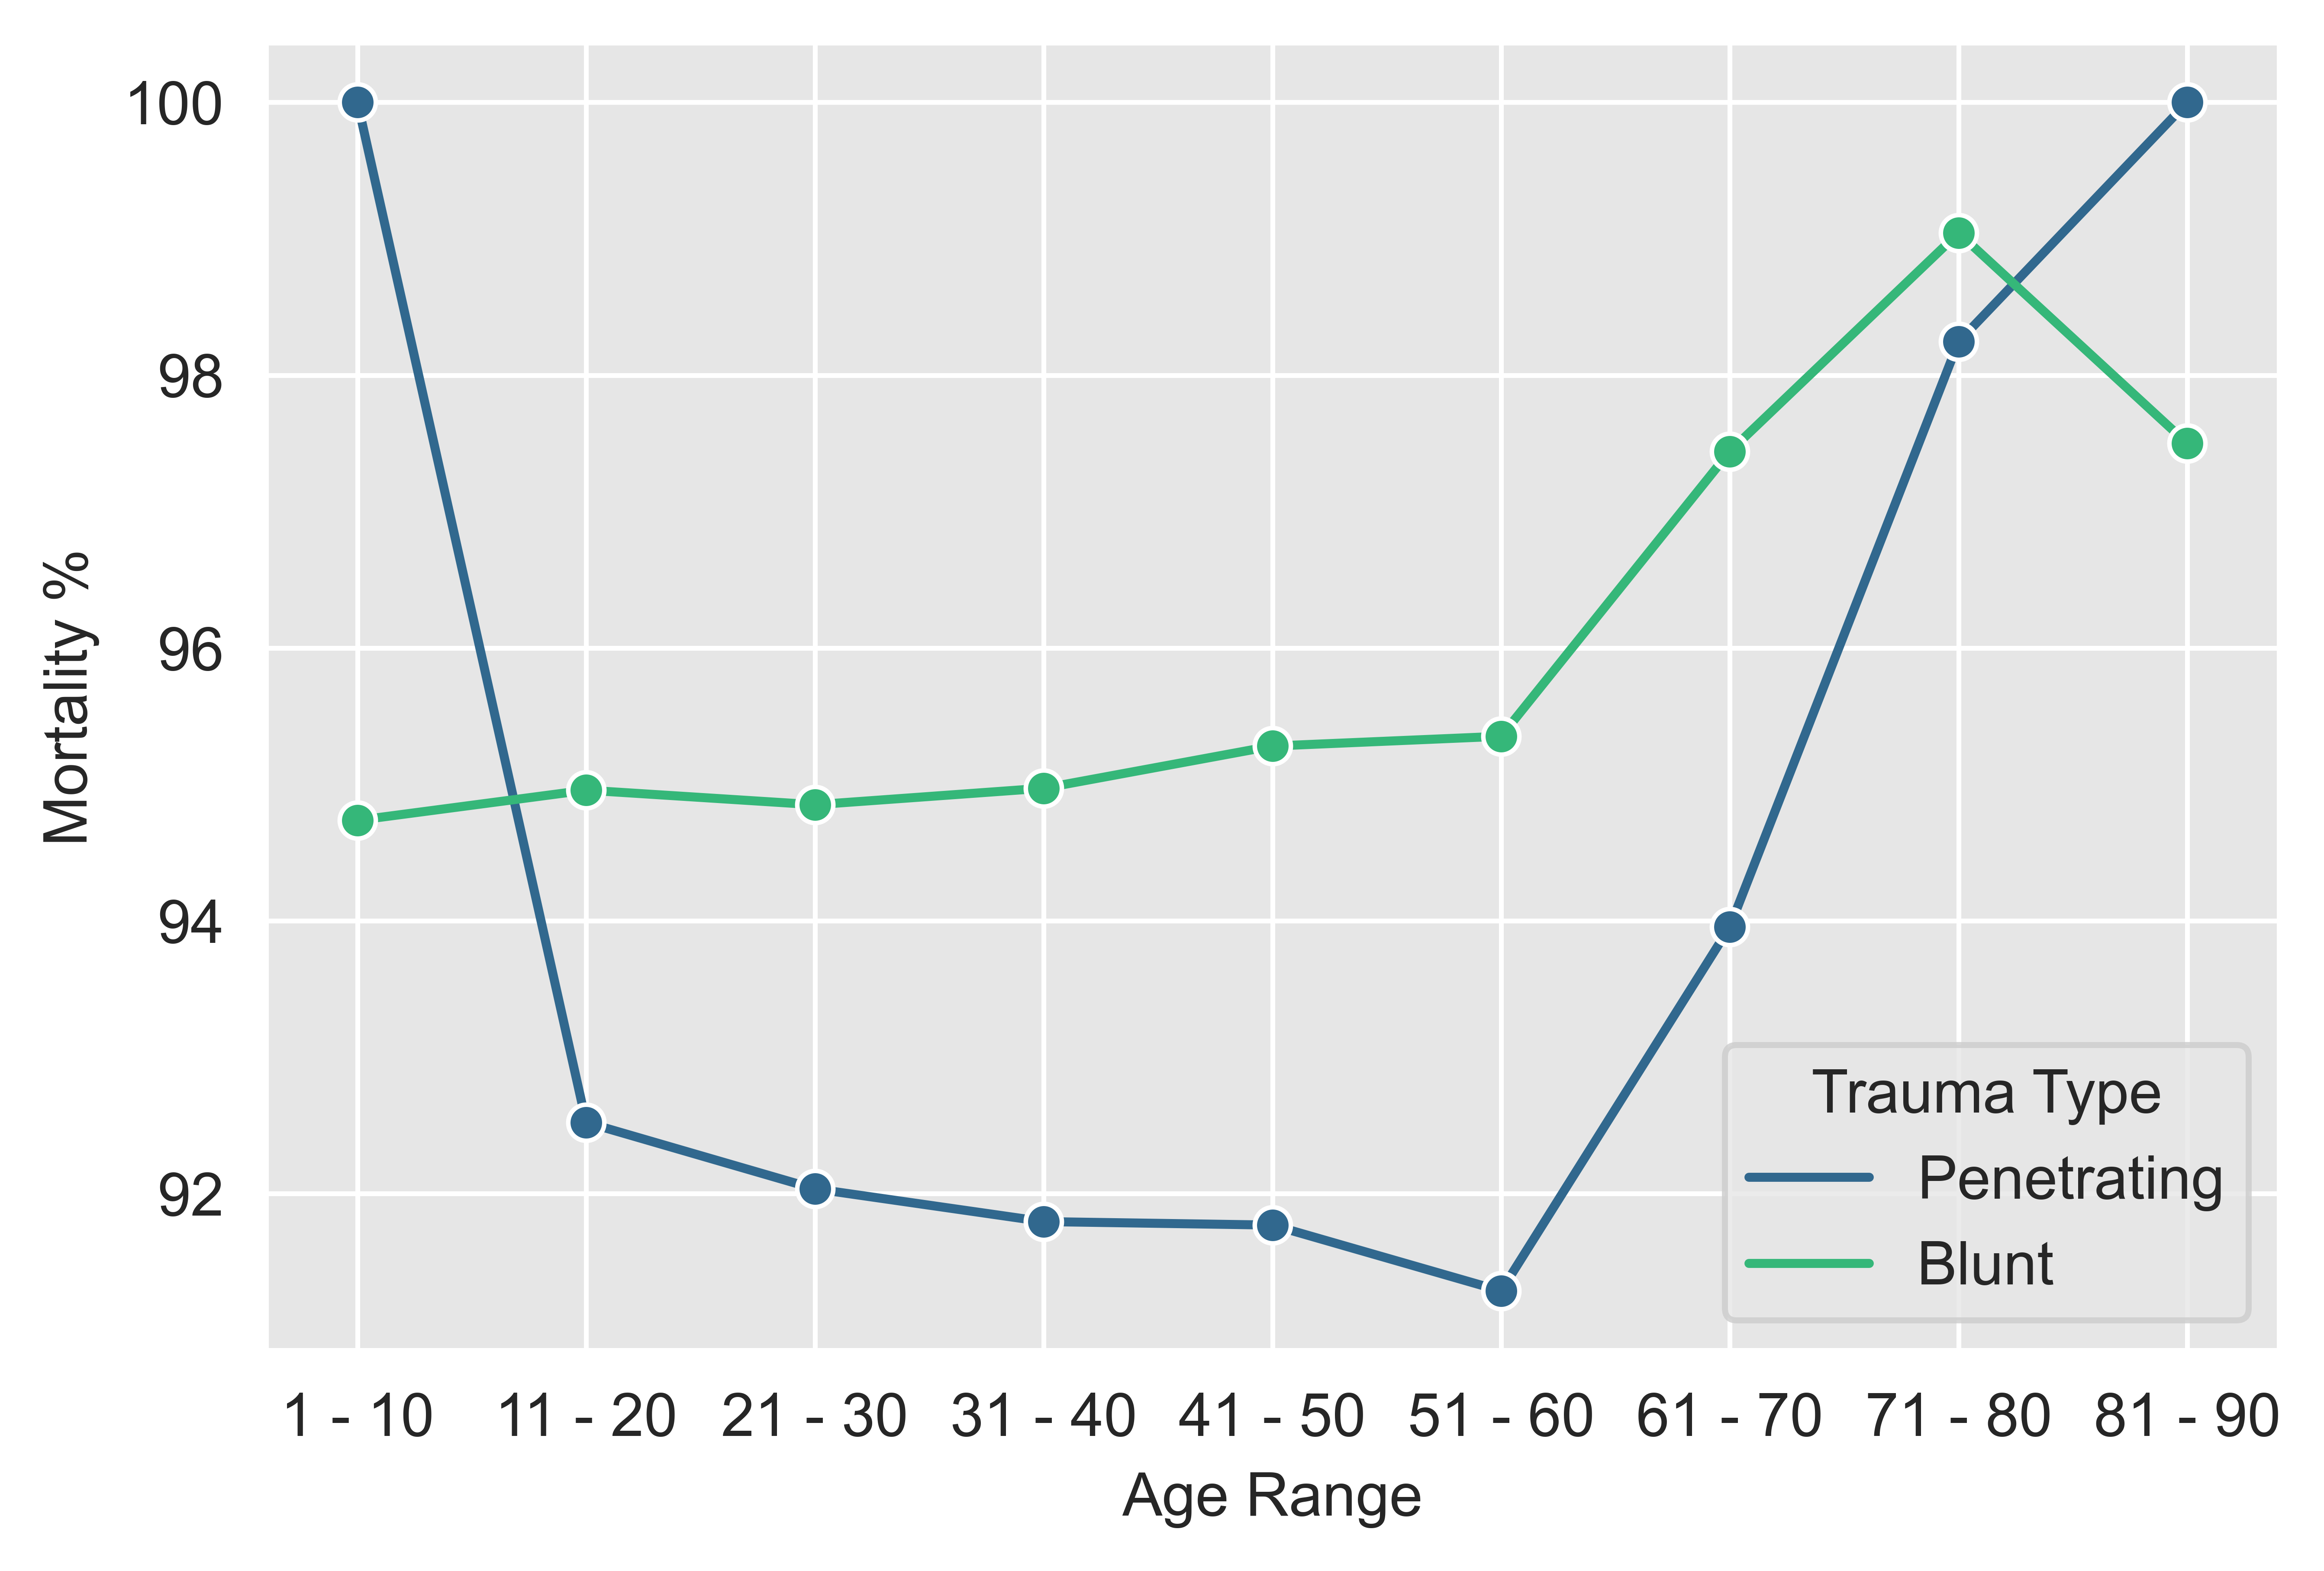

In [20]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_age_table,
               y='Mortality %',
               x='Age Range',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

## Create `DataFrame` of Mortality by `PROCEDUREMINS` and `Trauma Type`

In [37]:
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
proc_times = range(0,21, 1)

time_min_df = pd.DataFrame(columns=['INC_KEY', 'PROCEDUREMINS'])
for inc_key in np.unique(ICDPROCEDURE_all_df['INC_KEY']):
    inc_df = ICDPROCEDURE_all_df.loc[ICDPROCEDURE_all_df['INC_KEY'] == inc_key]
    first_proc_df = inc_df.loc[inc_df['PROCEDUREMINS'] == np.min(np.unique(inc_df['PROCEDUREMINS']))]
    if np.shape(first_proc_df)[0] == 0:
        continue
    first_proc_min = first_proc_df['PROCEDUREMINS'].tolist()[0]
    new_df = pd.DataFrame([[inc_key, first_proc_min]], columns=['INC_KEY', 'PROCEDUREMINS'])
    time_min_df = pd.concat([time_min_df, new_df])
    
for time in proc_times:
    time_min_keys = time_min_df.loc[time_min_df['PROCEDUREMINS'] == time]
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['INC_KEY'].isin(time_min_keys['INC_KEY'])]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    if np.shape(penetrating_df)[0] == 0:
        continue
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    if np.shape(blunt_df)[0] == 0:
        continue
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table)

INC_KEY  PROCEDUREMINS
0   170000018399            2.0
0   170000020428            1.0
0   170000021290            3.0
0   170000021466            0.0
0   170000022419            1.0
0   170000022714            0.0
0   170000022715            0.0
0   170000038042            5.0
0   170000050120            0.0
0   170000050379            1.0
0   170000052175           11.0
0   170000052288            3.0
0   170000057599            3.0
0   170000057961            1.0
0   170000058335            0.0
0   170000058411            0.0
0   170000059800            0.0
0   170000062926            0.0
0   170000063239            0.0
0   170000179545            3.0
0   170000183326            1.0
0   170000183686           10.0
0   170000185037            0.0
0   170000224400            1.0
0   170000235494            4.0
0   170000246001            0.0
0   170000246107            0.0
0   170000246118            0.0
0   170000246179            0.0
0   170000246515            0.0
..           ...            ...
0   220072159573            6.0
0   220072199911            7.2
0   220072229457            0.0
0   220072234957            1.2
0   220072274664            0.0
0   220072306470            0.0
0   220072306471            0.0
0   220072306587            0.0
0   220072306588            1.8
0   220072306601            0.0
0   220072308033            0.0
0   220072308119            1.8
0   220072316663            1.2
0   220072316691            3.0
0   220072320660            0.0
0   220072320670            1.2
0   220072320772            1.2
0   220072320974            0.0
0   220072321172            3.0
0   220072330070            0.0
0   220072330077            0.0
0   220072330117            0.0
0   220072330312            0.0
0   220072330323            0.0
0   220072330368            0.0
0   220072416596           13.2
0   220072417147            0.0
0   220072417788            0.0
0   220072418263            3.0
0   220072418942            0.0

[9303 rows x 2 columns]

Mortality %  Trauma Type Procedure Time (Minutes after ED Arrival)  \
0    95.428203  Penetrating                                         0   
1    97.247706        Blunt                                         0   
0    93.367347  Penetrating                                         1   
1    97.297297        Blunt                                         1   
0    91.764706  Penetrating                                         2   
1    96.610169        Blunt                                         2   
0    91.700405  Penetrating                                         3   
1    96.762590        Blunt                                         3   
0    91.304348  Penetrating                                         4   
1    95.121951        Blunt                                         4   
0    84.848485  Penetrating                                         5   
1    96.428571        Blunt                                         5   
0    83.236994  Penetrating                                         6   
1    97.500000        Blunt                                         6   
0    78.125000  Penetrating                                         7   
1   100.000000        Blunt                                         7   
0    72.000000  Penetrating                                         8   
1    94.444444        Blunt                                         8   
0    71.428571  Penetrating                                         9   
1    89.130435        Blunt                                         9   
0    80.000000  Penetrating                                        10   
1   100.000000        Blunt                                        10   
0    80.000000  Penetrating                                        11   
1    75.000000        Blunt                                        11   
0    62.068966  Penetrating                                        12   
1   100.000000        Blunt                                        12   
0    66.666667  Penetrating                                        13   
1    66.666667        Blunt                                        13   
0    72.727273  Penetrating                                        14   
1   100.000000        Blunt                                        14   
0    93.333333  Penetrating                                        15   
1   100.000000        Blunt                                        15   
0    50.000000  Penetrating                                        16   
1   100.000000        Blunt                                        16   
0    60.000000  Penetrating                                        17   
1   100.000000        Blunt                                        17   
0    87.500000  Penetrating                                        18   
1   100.000000        Blunt                                        18   
0    60.000000  Penetrating                                        19   
1   100.000000        Blunt                                        19   
0    50.000000  Penetrating                                        20   
1   100.000000        Blunt                                        20   

  # of Cases  
0       3106  
1       1199  
0        196  
1         74  
0        170  
1         59  
0        494  
1        278  
0         92  
1         41  
0         66  
1         28  
0        173  
1         80  
0         32  
1         18  
0         25  
1         18  
0         56  
1         46  
0         15  
1          7  
0          5  
1          4  
0         29  
1         10  
0          3  
1          6  
0         11  
1          2  
0         15  
1          2  
0          2  
1          2  
0          5  
1          1  
0         16  
1          4  
0          5  
1          3  
0          4  
1          1

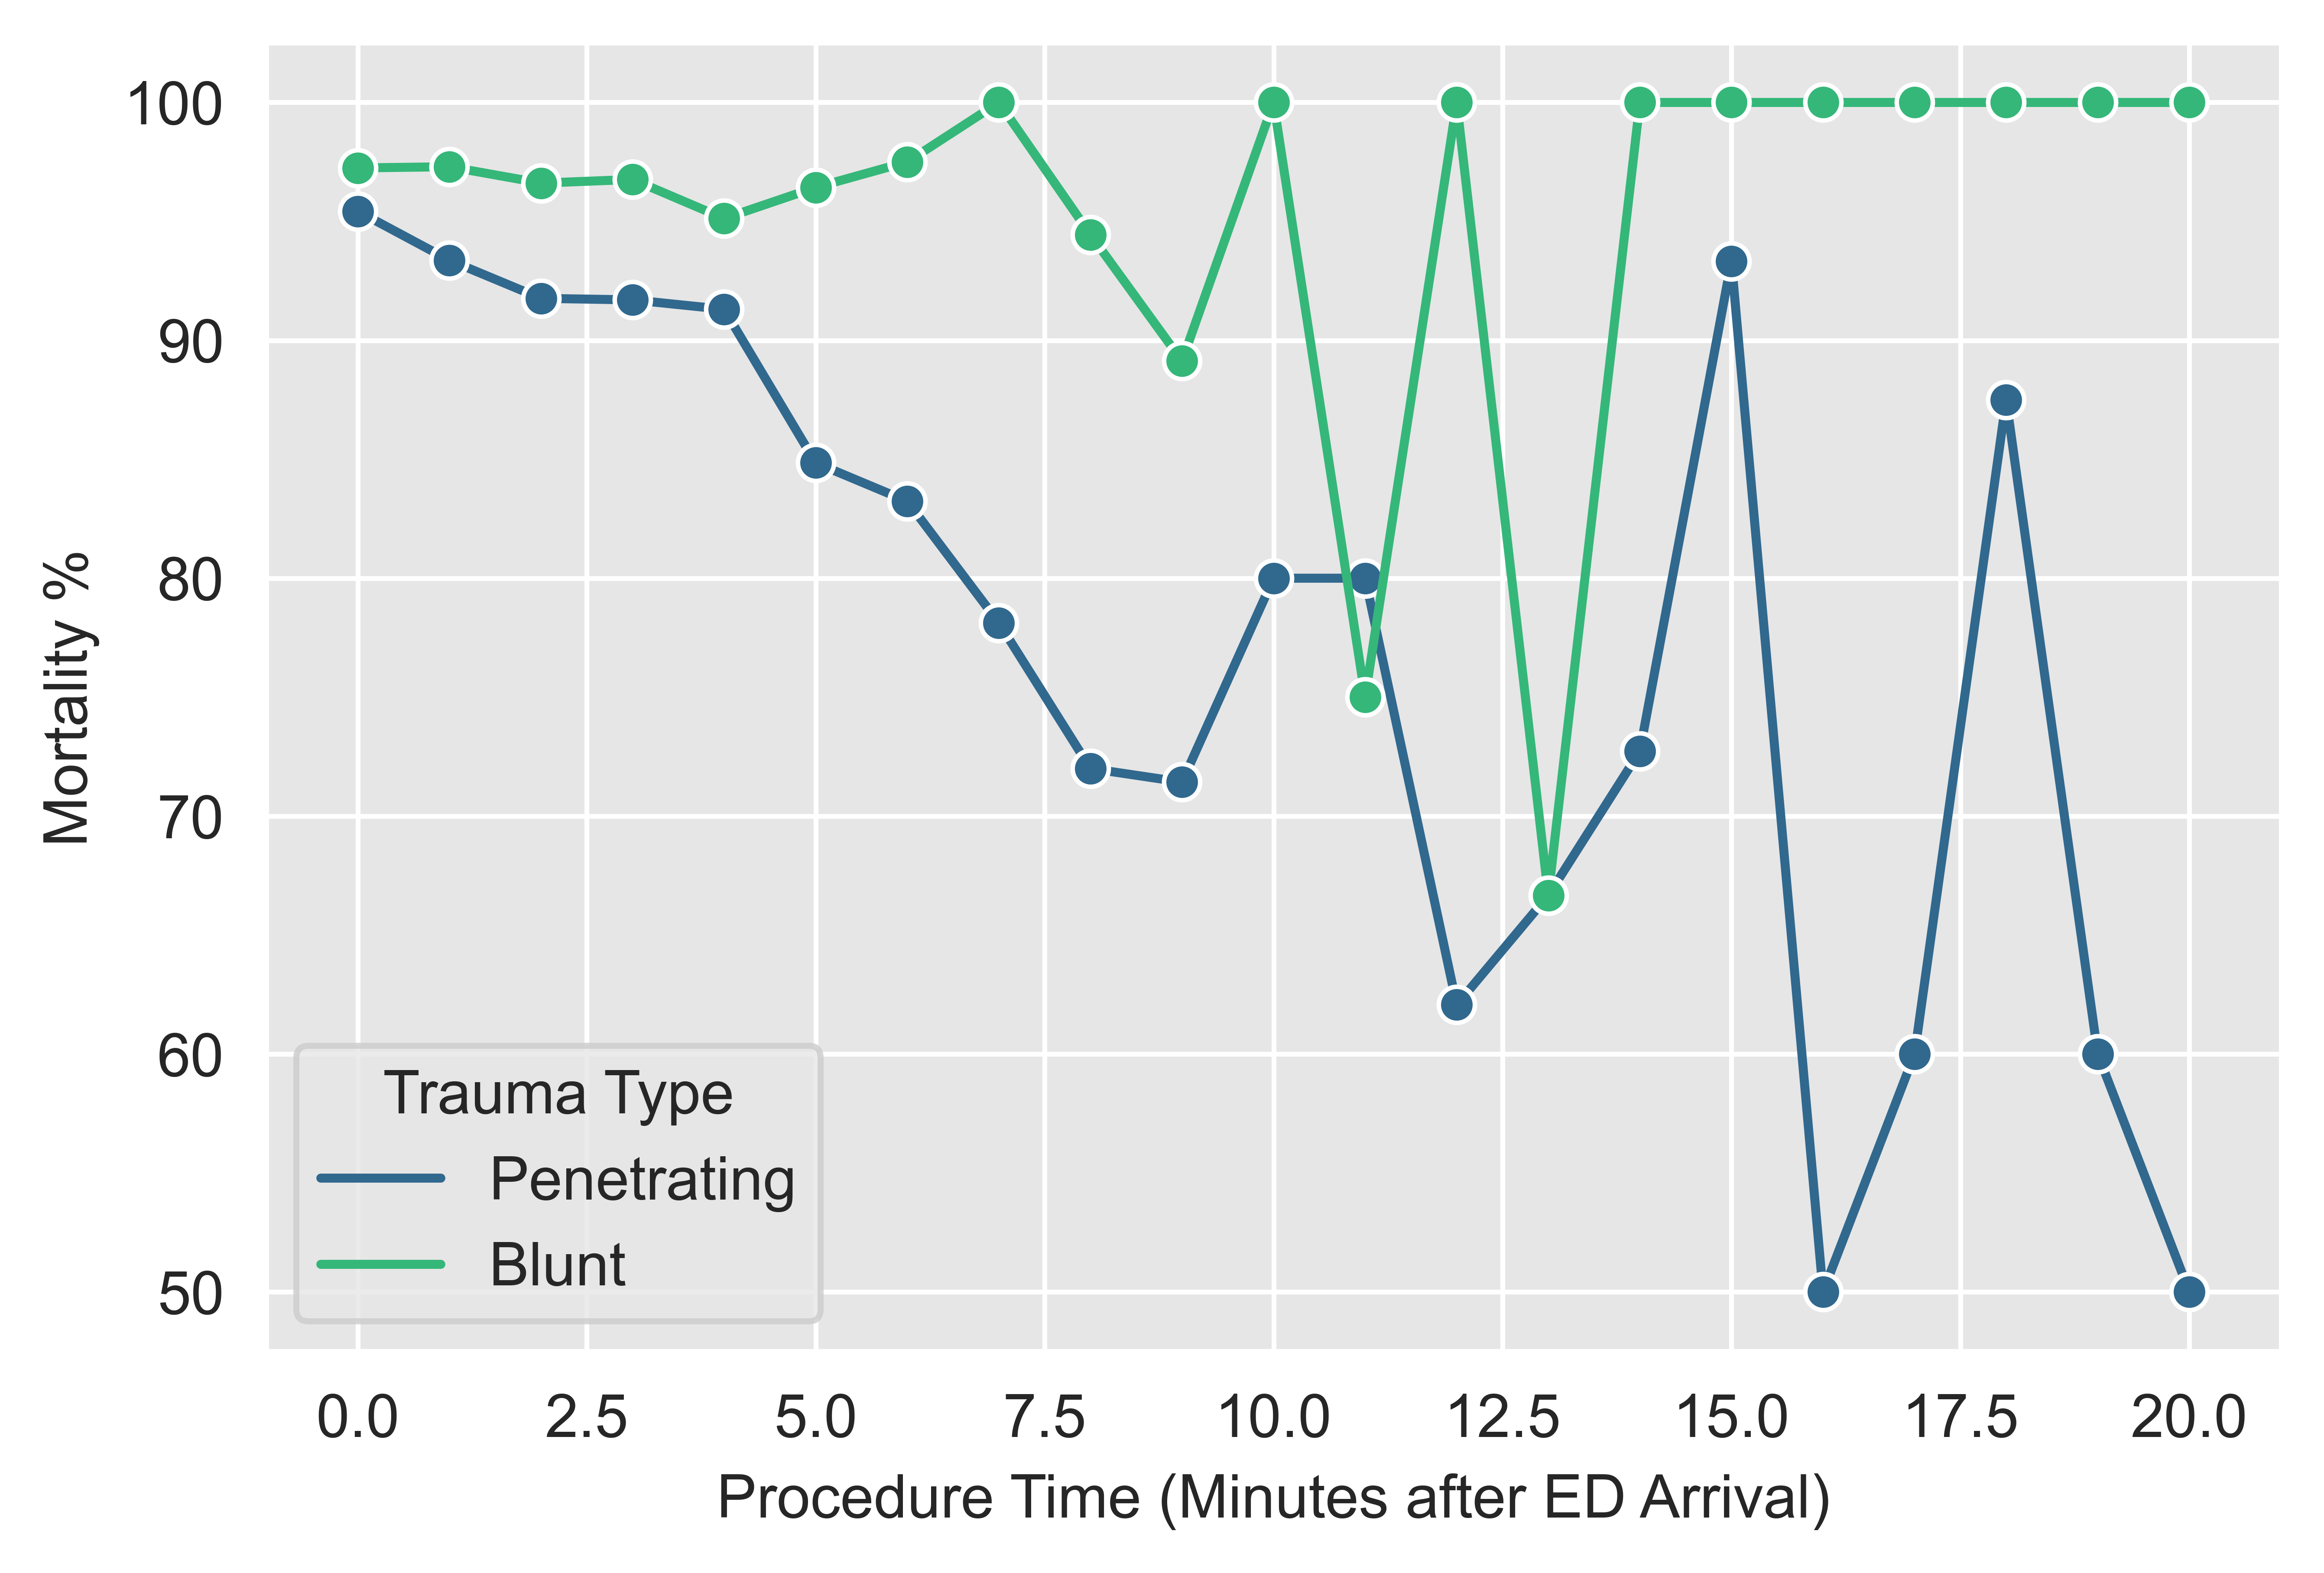

In [38]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_proctime_table,
               y='Mortality %',
               x='Procedure Time (Minutes after ED Arrival)',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

## Create Mortality Table for `Mechanism` and `Age Range`

> The below method should be adapted into the above scenarios for easier and more adaptable generation of tables

In [39]:
mortality_mechanism_table = pd.DataFrame(columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
age_ranges = range(0, 110, 10)
trauma_types = TRAUMA_all_df['MECHANISM'].unique()

for age_range in age_ranges:
    for trauma_type in trauma_types:
        age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range + 1) & (TRAUMA_all_df['AGEYEARS'] <= age_range + 10)]
        trauma_type_df = age_range_df[age_range_df['MECHANISM'] == trauma_type]
        
        if np.shape(trauma_type_df)[0] == 0:
            continue
        
        expired_df1 = trauma_type_df[trauma_type_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        expired_df2 = trauma_type_df[trauma_type_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        
        mortality_p = ((np.shape(expired_df1)[0] + np.shape(expired_df2)[0]) / np.shape(trauma_type_df)[0]) * 100
        
        final_df = pd.DataFrame([[mortality_p, trauma_type]], columns=['Mortality %', 'Mechanism'])
        final_df['Age Range'] = '%i - %i' % (age_range + 1, age_range + 10)
        final_df['# of Cases'] = np.shape(trauma_type_df)[0]
        
        combined_df = pd.DataFrame(final_df, columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
        mortality_mechanism_table = pd.concat([mortality_mechanism_table, combined_df])

mortality_mechanism_table['Mortality %'] = mortality_mechanism_table['Mortality %'].astype(float)
mortality_mechanism_table['Age Range'] = mortality_mechanism_table['Age Range'].astype(str)
mortality_mechanism_table.reset_index(drop=True, inplace=True)

display(mortality_mechanism_table.head())

Mortality %         Mechanism Age Range # of Cases
0        100.0           Firearm    1 - 10         45
1        100.0        Cut/pierce    1 - 10          4
2        100.0  MVT Motorcyclist    1 - 10          1
3        100.0      MVT Occupant    1 - 10         27
4        100.0              Fall    1 - 10          2

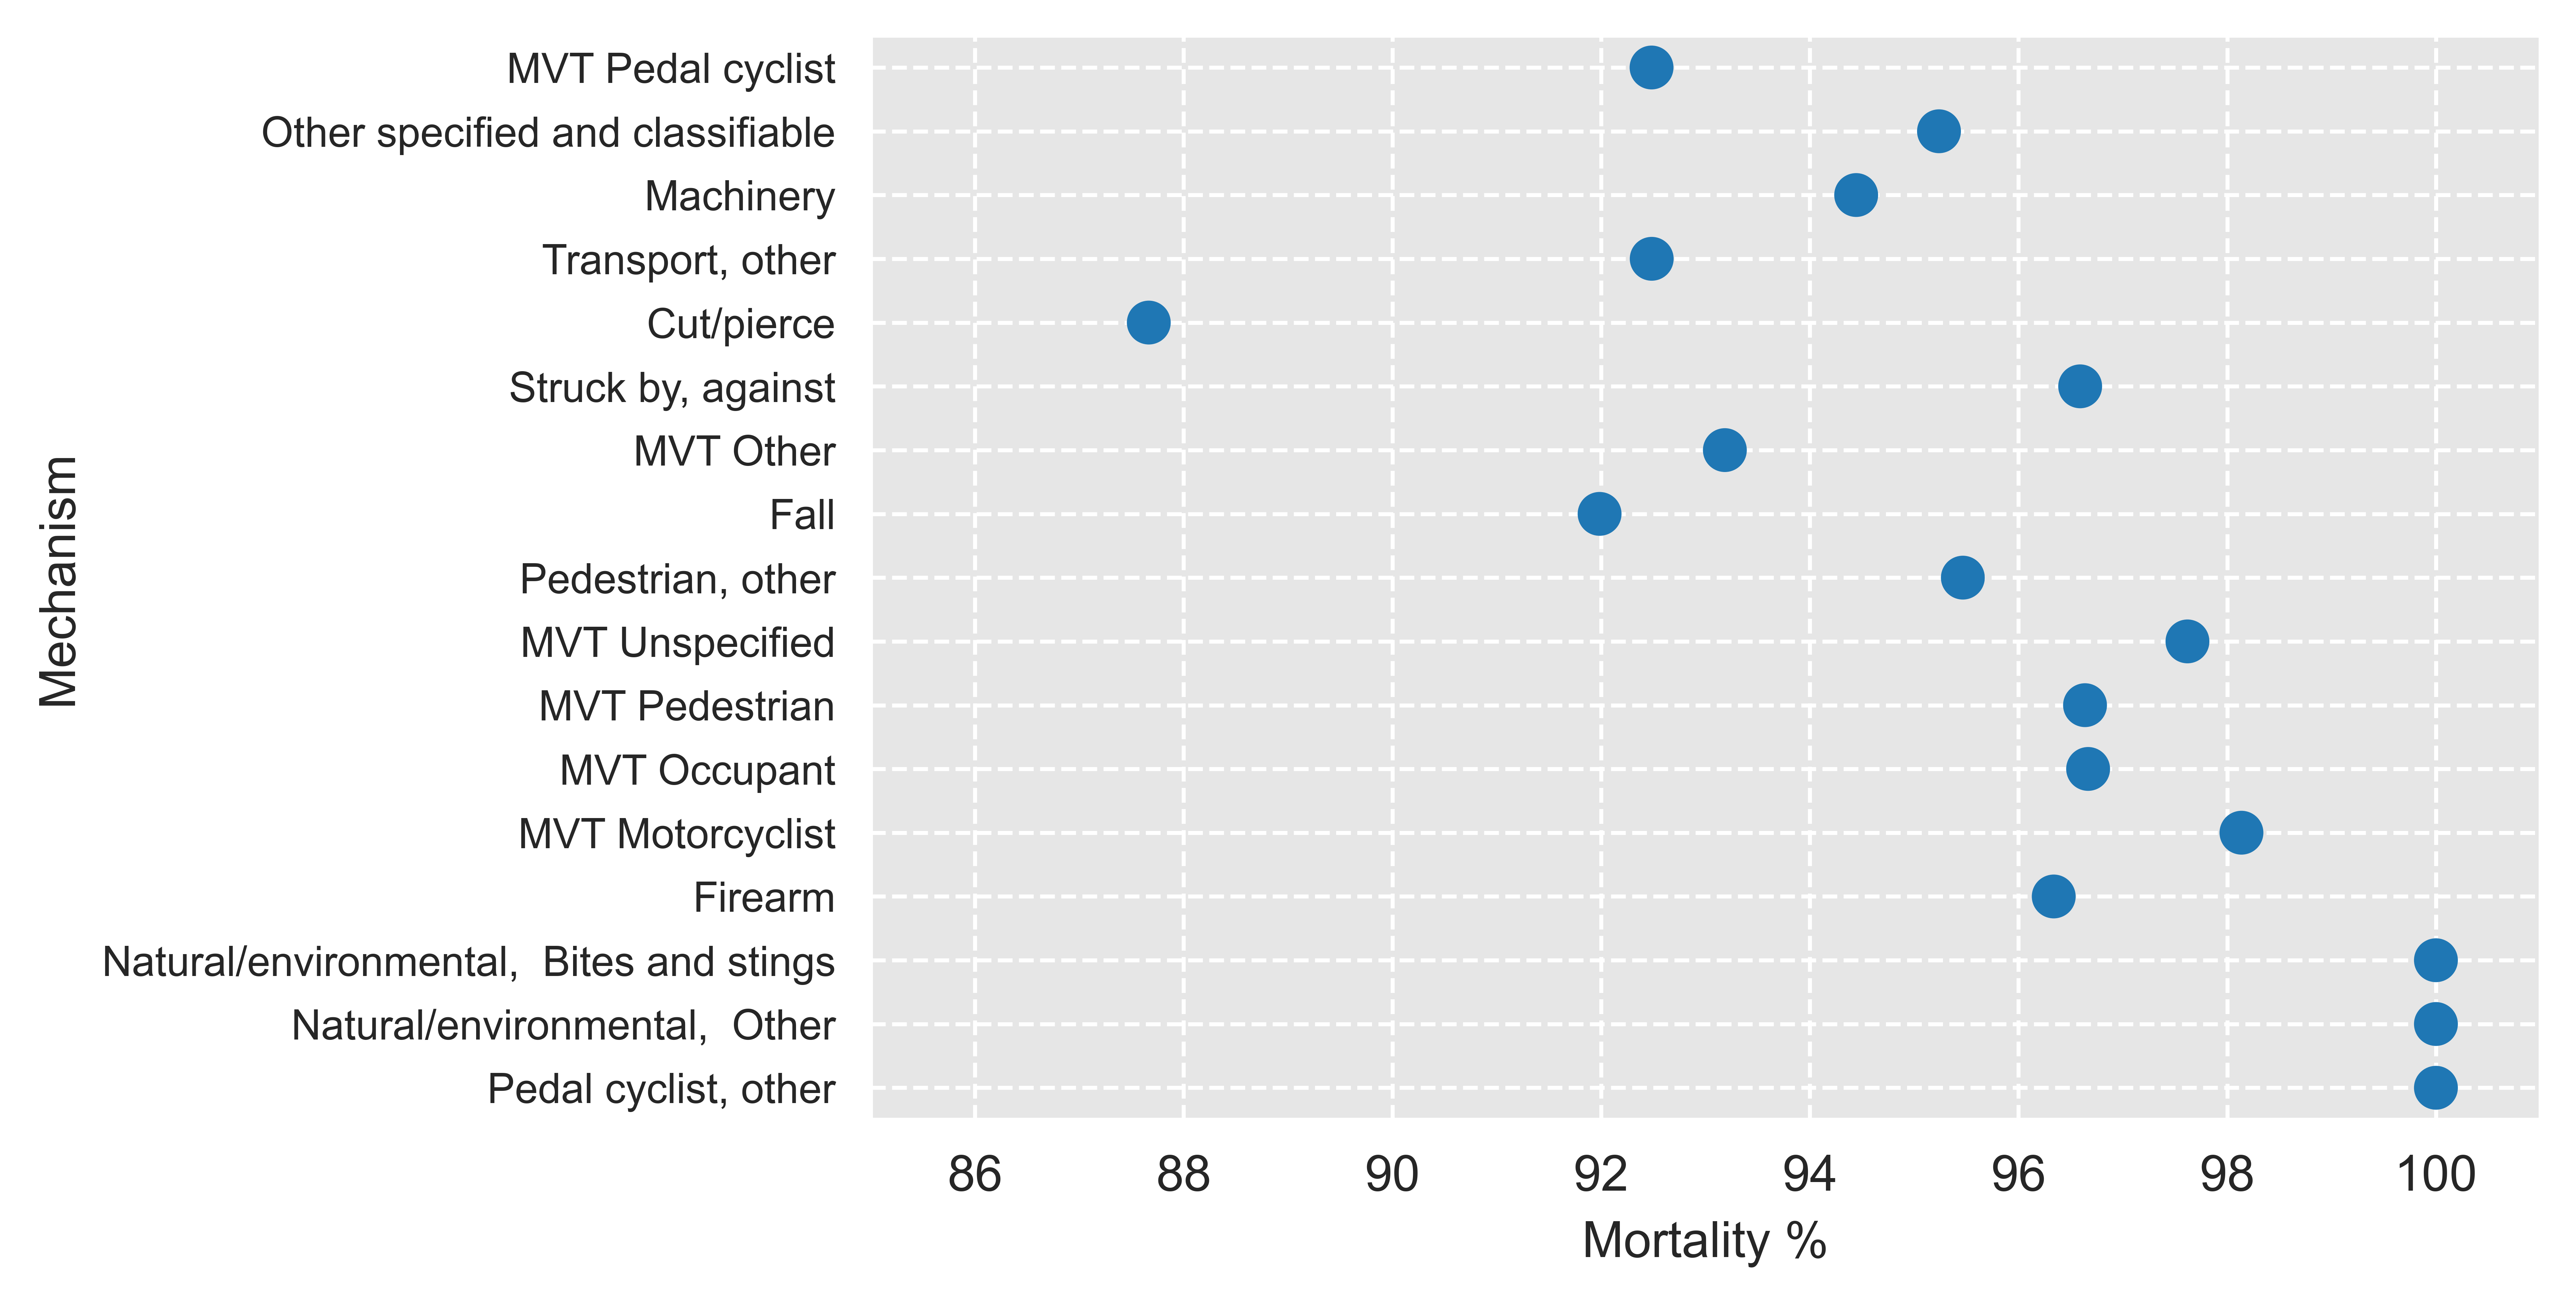

In [48]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.pointplot(data=mortality_mechanism_table,
               x='Mortality %',
               y='Mechanism', 
               ci=None,
               orient='h',
               join=False)
g.tick_params(axis='y', rotation=0, labelsize='small')
plt.grid(True, which='both', linestyle='--')
g.set_xlim(85, 101)
plt.show()

# `MAJOR FINDING: THERE IS LITERALLY A STUPID DATA FIELD THAT IS FOR DAMAGE CONTROL SURGERY AND THE MINUTES FROM ARRIVAL THAT USES THE WORD THORACOTOMY I HATE ALL OF THE THINGS`

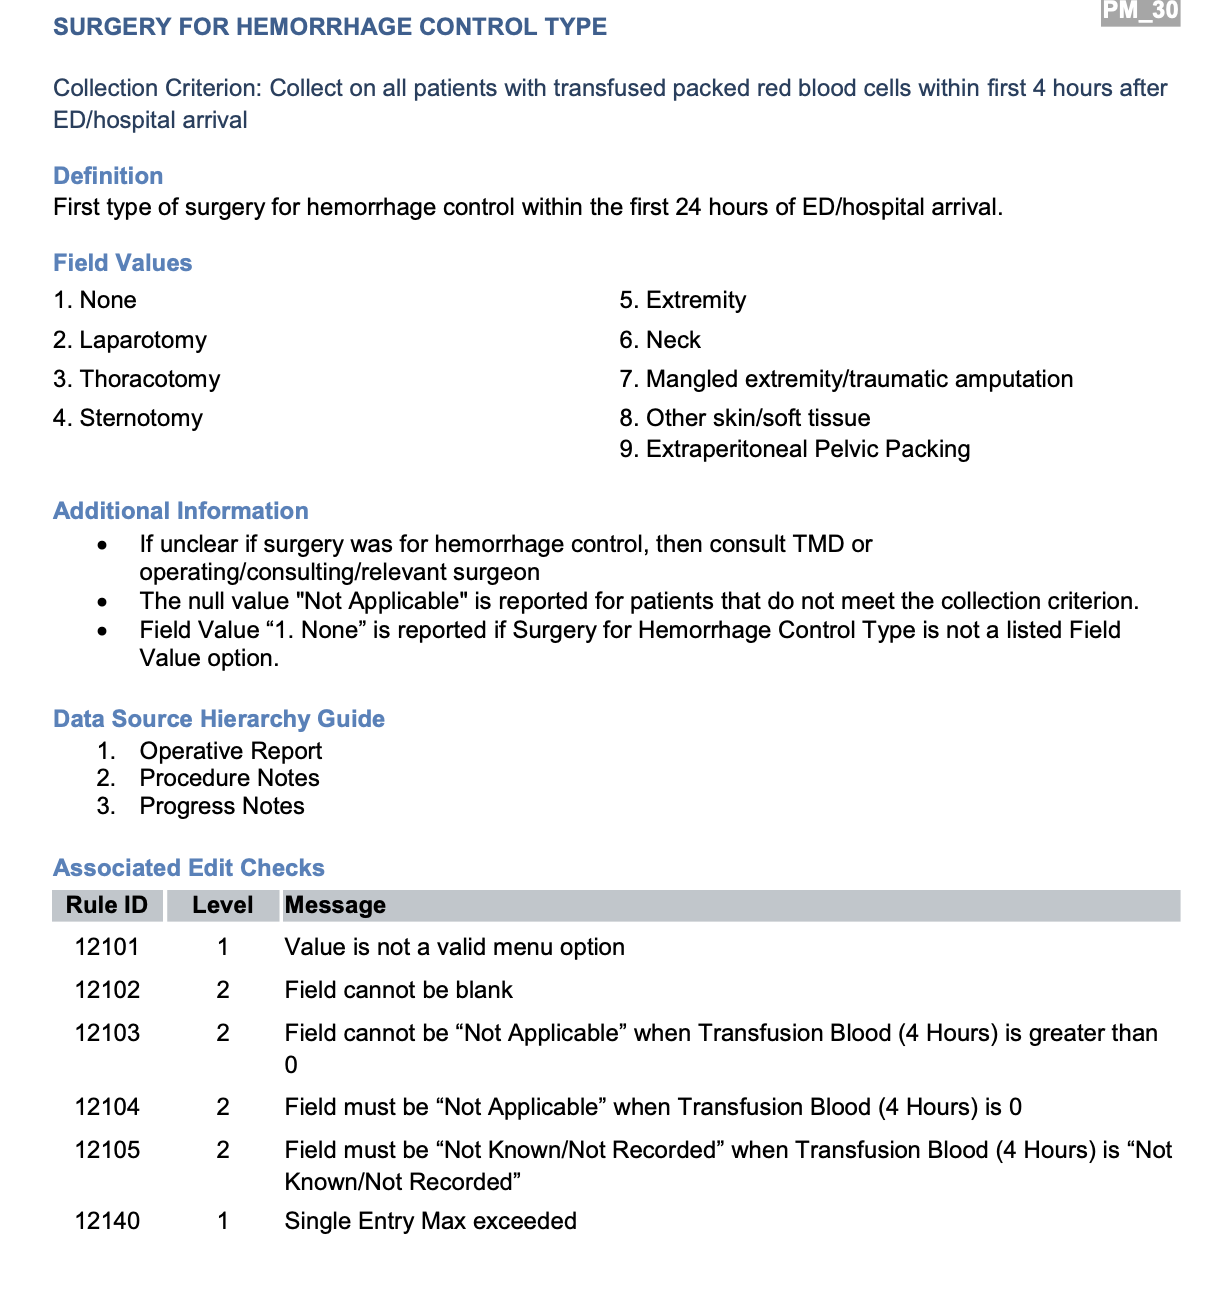

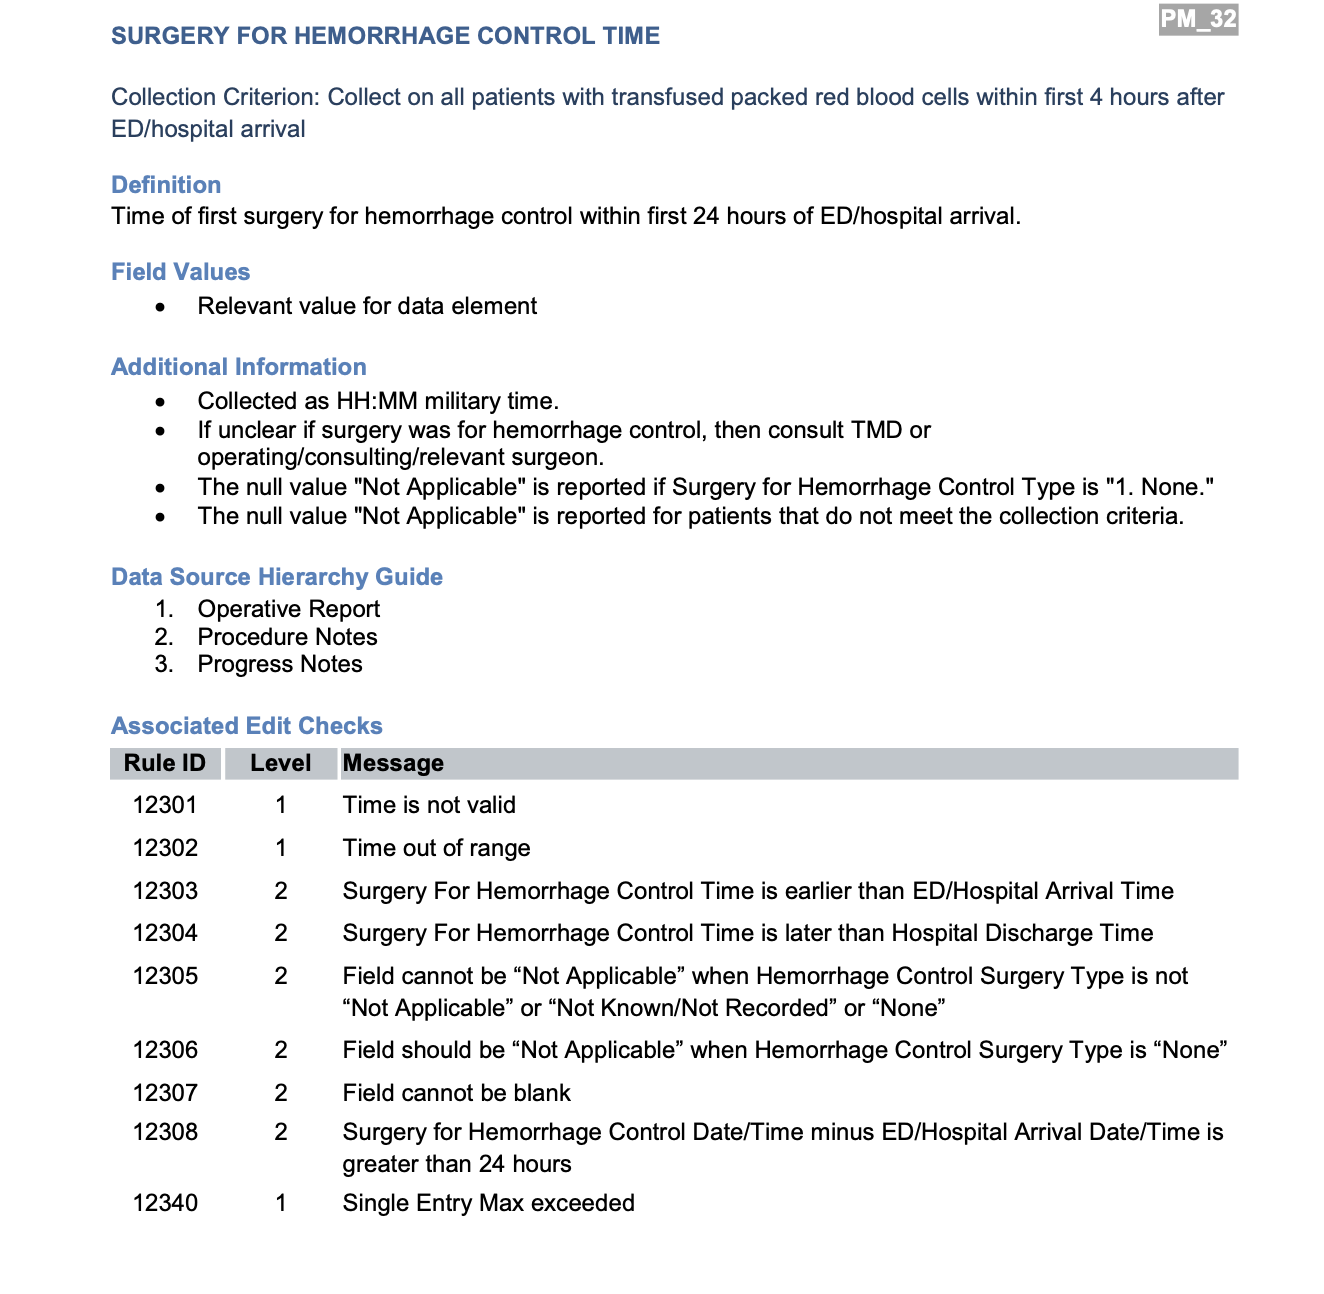

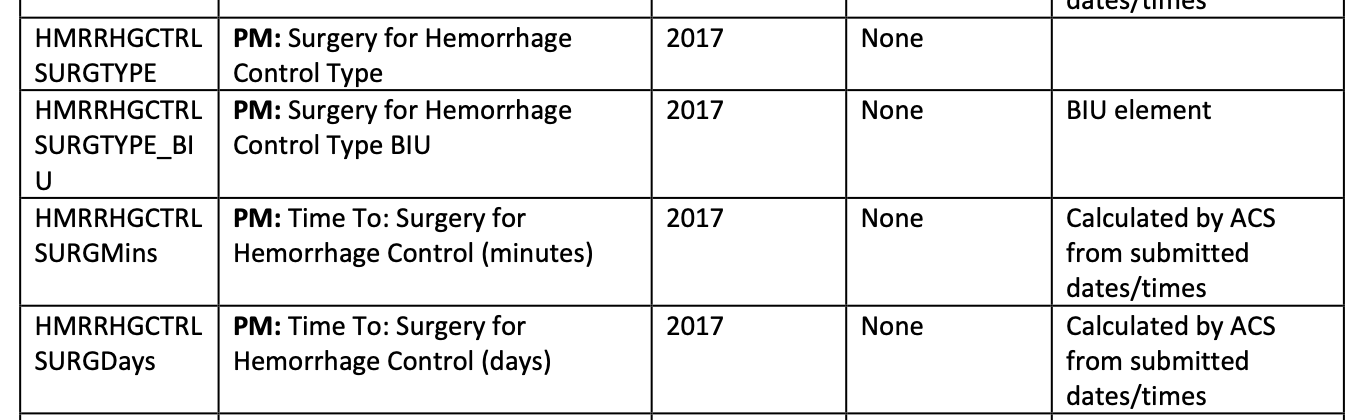

# Created a new notebook to show the results using These Damage Control Surgery Data Fields Separately to Compare to my filters